<a href="https://colab.research.google.com/github/Pasewark/LSC/blob/main/SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as f
import torch.nn as nn
import importlib
import torchvision
import torchvision.datasets as datasets
import time
import lsc
import sc
import matplotlib.animation as animation
import utils
import image_transform as img_tran
import os
import shutil
import geoopt
import geotorch

In [ ]:
# torch.set_default_tensor_type(torch.cuda.FloatTensor)
torch.cuda.set_device(0) #use GPU 0

In [ ]:
def plot_psi(psi, rgb=False, show=False, save=None, box_margins=[0.05,0.95,0.95,0.05]):
    fig = plt.figure(figsize=(10,int(K/10)))
    for k in range(K):
        fig.add_subplot(int(K/10),10,k+1)
        plt.xticks([])
        plt.yticks([])
        if rgb:
            plt.imshow((psi[:,k]/psi[:,k].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
        else:
            plt.imshow(psi[:,k].reshape(dim,dim).cpu(), cmap="Greys")
#     plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, left=box_margins[0], right=box_margins[1], top=box_margins[2], bottom=box_margins[3])
    if save is not None:
        plt.savefig(save)
    if show:
        plt.show()
    plt.close(fig)

def plot_w(w, rgb=False, show=False, save=None, cols=16):
    fig = plt.figure(figsize=(cols,int(L*2/cols)))
    for i in range(L*2):
        fig.add_subplot(int(L*2/cols),cols,i+1)
        plt.xticks([])
        plt.yticks([])
        if rgb:
            plt.imshow((w[:,i]/w[:,i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
        else:
            plt.imshow(w[:,i].reshape(dim,dim).cpu(), cmap="Greys")
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    if show:
        plt.show()
    plt.close(fig)
    
def plot_operator(s_ratio, show=False, save=None, use_psi=False, rgb=False, rmin=-np.pi, rmax=np.pi, N_figs=19, K=10, box_margins=[0.05,0.95,0.95,0.05], hspace=0.0,wspace=0.0):
    if use_psi:
        x = psi[:,:K].clone().t()
    else:
        x = next(iter(test_dl))[:K]

    w1, w2 = w[:,::2], w[:,1::2] # (D,L), (D,L)
    u1 = torch.einsum('dj, bd -> bj', w1, x) # (B,L)
    u2 = torch.einsum('dj, bd -> bj', w2, x) # (B,L)

    y_hat = torch.zeros(K,N_figs,D)
    for j in range(N_figs):
        s = torch.from_numpy(np.array(s_ratio)*np.linspace(rmin, rmax, num=N_figs)[j]).cuda()
        m_hat = torch.einsum('jn,n->j',omega.float(), s.float())
        ru1, ru2 = lsc.rot(m_hat.float(), u1, u2)
        ru = torch.zeros((K,L*2)).cuda() # (K,L*2) = (B,L*2)
        ru[:,::2] = ru1
        ru[:,1::2] = ru2
        y_hat[:,j,:] = torch.einsum('dj, bj -> bd', w, ru) # (B,D)

    fig = plt.figure(figsize=(N_figs,K))
    for i in range(K):
        for j in range(N_figs):
            fig.add_subplot(K,N_figs,i*N_figs+j+1)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((y_hat[i,j]/y_hat[i,j].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(y_hat[i,j].reshape(dim,dim).cpu(), cmap="Greys", vmin=y_hat[:,j].min().cpu(), vmax=y_hat[:,j].max().cpu())
#     plt.tight_layout()
    plt.subplots_adjust(wspace=wspace,hspace=hspace,left=box_margins[0],right=box_margins[1],top=box_margins[2],bottom=box_margins[3])
    if save is not None:
        plt.savefig(save)
    if show:
        plt.show()
    plt.close(fig)
    
def plot_reconstruction(dl, alpha_0=0.01, show=False, save=None, three_d=False, plot_marginals=False,rgb=False,N=100,expanded=False,M=30):
    # Generate Data
    y = next(iter(dl))[:M]
    if k is not None and m is not None:
        mod_k, mod_m = k[:M], m[:M]
    else:
        mod_k, mod_m = None, None

    alpha = torch.ones(M,K).cuda()*alpha_0
    alpha = lsc.alpha_update_FISTA(y, psi, w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=plot, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

    # Calculate useful variables (This and following parts total: 0.015s)
    x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, psi, w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)
    
    nll = -lsc.log_likelihood(x, y, u, v, psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
    
    unique_omega = torch.unique(omega, dim=0) # (L,n)
    post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N) # (M,N,N)
    s_hat = utils.get_MAP(post)
    recon = lsc.reconstruct(x, w, s_hat, omega)
    
    if expanded:
        cols = 3+omega.size()[1]+psi.size()[1]
        fig = plt.figure(figsize=(cols,M))
        for i in range(M):
            fig.add_subplot(M,cols,i*cols+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(y[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(M,cols,i*cols+1+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(recon[i].cpu().reshape((dim,dim)),cmap="Greys")
            marginals = utils.marginalize_distribution(post) # (K,N,n)
            t = np.linspace(-np.pi,np.pi,num=marginals.shape[1])
            for j in range(omega.size()[1]):
                fig.add_subplot(M,cols,i*cols+1+1+j+1)
                plt.xticks(ticks=[-np.pi,0,np.pi],labels=[r'$-\pi$',0,r'$\pi$'])
                plt.yticks([])
                plt.plot(t,marginals[i,:,j])
            fig.add_subplot(M,cols,i*cols+1+1+omega.size()[1]+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(torch.einsum('dk,k->d',psi,alpha[i]).cpu().reshape((dim,dim)),cmap="Greys")
            vmin, vmax = torch.min(torch.einsum('dk,k->dk',psi,alpha[i])), torch.max(torch.einsum('dk,k->dk',psi,alpha[i]))
            for j in range(psi.size()[1]):
                fig.add_subplot(M,cols,i*cols+1+1+omega.size()[1]+1+j+1)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(psi[:,j].cpu().reshape((dim,dim))*alpha[i,j],vmin=vmin,vmax=vmax,cmap="Greys")
        plt.tight_layout(h_pad=0.0,w_pad=0.0)
    else:
        if three_d:
            tx, ty = np.linspace(-np.pi, np.pi, num=post.shape[1]), np.linspace(-np.pi, np.pi, num=post.shape[2])
            gx, gy = np.meshgrid(tx, ty)
        if plot_marginals:
            marginals = utils.marginalize_distribution(post) # (K,N,n)
            t = np.linspace(-np.pi,np.pi,num=marginals.shape[1])
        nfigs = 4 + omega.size()[1] if plot_marginals else 5
        cols = nfigs*3
        fig = plt.figure(figsize=(cols,10))
        for i in range(M):
            fig.add_subplot(10,cols,i*nfigs+1)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((y[i]/y[i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(y[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(10,cols,i*nfigs+2)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((recon[i]/recon[i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(recon[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(10,cols,i*nfigs+3)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((x[i]/x[i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(x[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(10,cols,i*nfigs+4)
            plt.xticks([])
            plt.yticks([])
            plt.bar(np.arange(alpha.size()[1]), alpha[i].cpu())
            if three_d:
                ax = fig.add_subplot(10,cols,i*nfigs+5, projection='3d')
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])
                ax.plot_surface(gx, gy, post[i])
            elif plot_marginals:
    #             print(marginals.shape)
                for j in range(omega.size()[1]):
                    fig.add_subplot(10,cols,i*nfigs+5+j)
                    plt.yticks([])
                    plt.plot(t,marginals[i,:,j])
            else:
                fig.add_subplot(10,cols,i*nfigs+5)
                plt.xticks([])
                plt.yticks([])
                plt.bar(np.arange(s_hat.size()[1]), s_hat[i].cpu())
    if save is not None:
        plt.savefig(save)
    if show:
        plt.show()
    plt.close(fig)
    
def save_loss(train_loss, test_loss, save):
    f = open(save, 'a')
    np.savetxt(f, np.array([train_loss, test_loss])[np.newaxis,:])
    f.close()
    
def plot_loss(load,show=True,save=None,validation_only=True):
    losses = np.loadtxt(load)
    train_loss, test_loss = losses[:,0], losses[:,1]
    eps = len(train_loss)
    if validation_only:
        plt.plot(np.arange(eps),test_loss,label="Validation Loss")
    else:
        plt.plot(np.arange(eps),train_loss,label="Training Loss")
        plt.plot(np.arange(eps),test_loss,label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Negative Log Likelihood)")
    if save:
        plt.savefig(save)
    if show:
        plt.show()
        
def get_MNIST_dataloader(B, cuda=False, dim=28):
    # Load mnist dataset.
#     transform = torchvision.transforms.Compose([
#         torchvision.transforms.ToTensor()
#     ])
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((dim,dim)),
        torchvision.transforms.ToTensor()
    ])
    mnist_trainset = datasets.MNIST(root='./datasets', train=True, download=True, transform=transform)
    mnist_testset = datasets.MNIST(root='./datasets', train=False, download=True, transform=transform)
    trainset_size = len(mnist_trainset)
    testset_size = len(mnist_testset)
    train_dl = torch.utils.data.DataLoader(dataset=mnist_trainset, batch_size=trainset_size, shuffle=True)
    test_dl = torch.utils.data.DataLoader(dataset=mnist_testset, batch_size=testset_size, shuffle=True)
    
    num_train_batches, num_test_batches = trainset_size//B, testset_size//B
    assert num_train_batches*B == trainset_size
    assert num_test_batches*B == testset_size
    
    dim = next(iter(train_dl))[0].squeeze().size()[1]
    D = dim*dim
    new_train_dl = next(iter(train_dl))[0].squeeze().view(num_train_batches,B,D).cuda()
    new_test_dl = next(iter(test_dl))[0].squeeze().view(num_test_batches,B,D).cuda()
    
    new_train_dl = f.normalize(new_train_dl,dim=2)
    new_test_dl = f.normalize(new_test_dl,dim=2)
    
    if cuda:
        return new_train_dl, new_test_dl, dim, D, num_train_batches, num_test_batches
    else:
        return new_train_dl.cpu(), new_test_dl.cpu(), dim, D, num_train_batches, num_test_batches
    
class CustomDataLoader:
    def __init__(self, dataloader, B, D):
        self.dataloader = dataloader
        self.B = B
        self.D = D
    def __iter__(self):
        self.it = iter(self.dataloader)
        return self
    def __next__(self):
        try:
            batch = next(self.it)[0].view(self.B,self.D).cuda()
            return f.normalize(batch,dim=1)
        except StopIteration:
            raise StopIteration
            
def get_custom_dataloader(B, train_l=6000, test_l=1000, dx=[0.0,0.0], dy=[0.0,0.0], dr=[0.0,0.0], ds=[1.0,1.0], thicken=False, wrap=False, shuffle=True, cuda=False, dim=28):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((dim,dim)),
        torchvision.transforms.ToTensor()
    ])
    mnist_trainset = datasets.MNIST(root='./datasets', train=True, download=True, transform=transform)
    mnist_dl = torch.utils.data.DataLoader(dataset=mnist_trainset, batch_size=1000, shuffle=False)
    batch = next(iter(mnist_dl))
    y = batch[0].squeeze() # (1000,dim,dim)
    labels = batch[1] # (1000)
    dl_batch_size, dim = y.size()[0], y.size()[1]
    center = ((dim)/2,(dim)/2)
    D = dim*dim
    N = 10
    num_train_batches, num_test_batches = N*train_l//B, N*test_l//B
    assert num_train_batches*B == N*train_l
    assert num_test_batches*B == N*test_l
    
    y = y.view(dl_batch_size,D)
    digits = torch.zeros((N,D))
    for i in range(10):
        idx = labels == i
        digits[i*(N//10):(i+1)*(N//10)] = y[idx][:(N//10)]
#         digits[i:i+1] = y[idx][np.random.choice(len(y[idx]))]

    train_video = torch.zeros(N,train_l,D)
    for i, digit in enumerate(digits):
        shift_x = torch.from_numpy(np.random.uniform(dim*dx[0],dim*dx[1],train_l))
        shift_y = torch.from_numpy(np.random.uniform(dim*dy[0],dim*dy[1],train_l))
        rotation = torch.from_numpy(np.random.uniform(dr[0],dr[1],train_l))
        scaling = torch.from_numpy(np.random.uniform(ds[0],ds[1],train_l))
        x = digit.repeat(train_l,1).view(train_l,dim,dim)
        y = img_tran.affine_2D(x, shift_x, shift_y, rotation, scaling, wrap_around=wrap)
        if thicken:
            sigma = torch.from_numpy(np.random.uniform(0.01,1.0,train_l))
            y = img_tran.thicken(y, sigma)
        train_video[i] = y.view(train_l,D)
        
    test_video = torch.zeros(N,test_l,D)
    for i, digit in enumerate(digits):
        shift_x = torch.from_numpy(np.random.uniform(dim*dx[0],dim*dx[1],test_l))
        shift_y = torch.from_numpy(np.random.uniform(dim*dy[0],dim*dy[1],test_l))
        rotation = torch.from_numpy(np.random.uniform(dr[0],dr[1],test_l))
        scaling = torch.from_numpy(np.random.uniform(ds[0],ds[1],test_l))
        x = digit.repeat(test_l,1).view(test_l,dim,dim)
        y = img_tran.affine_2D(x, shift_x, shift_y, rotation, scaling, wrap_around=wrap)
        if thicken:
            sigma = torch.from_numpy(np.random.uniform(0.01,1.0,test_l))
            y = img_tran.thicken(y, sigma)
        test_video[i] = y.view(test_l,D)
    
    train_video = f.normalize(train_video.view(N*train_l,D).cuda(),dim=1)
    test_video = f.normalize(test_video.view(N*test_l,D).cuda(),dim=1)
    
    if shuffle:
        train_video = train_video[torch.randperm(N*train_l)]
        test_video = test_video[torch.randperm(N*test_l)]
    
    if cuda:
        return train_video.view(num_train_batches,B,D), test_video.view(num_test_batches,B,D), dim, D, num_train_batches, num_test_batches
    else:
        return train_video.view(num_train_batches,B,D).cpu(), test_video.view(num_test_batches,B,D).cpu(), dim, D, num_train_batches, num_test_batches
    
def initialize_omega(n, L, o_max, multiplicity):
    if n == 1:
        omega = torch.arange(o_max).cuda().int().unsqueeze(1) # (ceil(o_max),1)
    elif n == 2: # n == 2
        omega_x = torch.arange(o_max).cuda() # (ceil(o_max))
        omega_y = torch.arange(-int(o_max), o_max).cuda() # (2*ceil(o_max)-1)
        omega = torch.stack(torch.meshgrid(omega_x, omega_y),dim=2).view(-1,2) # get list of points
        omega = omega[omega.float().norm(dim=1) <= o_max] # select points inside circle with radius o_max
        omega = omega[(omega[:,1] >= 0) + (omega[:,0] != 0)] # remove points on y-axis with negative y coordinates
        # sort by radius first, then by angle
        omega = torch.from_numpy(np.array(sorted(omega.cpu().numpy(),key=lambda x: (np.sum(x**2),np.arctan2(x[1],x[0]))))).cuda().int()
    else:
        omega_n = torch.arange(-int(o_max), o_max).cuda().repeat(n,1) # (n,2*ceil(o_max)-1)
        omega = torch.stack(torch.meshgrid(*omega_n),dim=n).view(-1,n) # ((2*ceil(o_max)-1)^n,n)
        omega = omega[omega.float().norm(dim=1) <= o_max].cpu().numpy() # select points inside n-sphere with radius o_max
        filtered_omega = []
        for o in omega:
            if tuple(-o) not in filtered_omega:
                filtered_omega.append(tuple(o))
        omega = torch.from_numpy(np.array(sorted(np.array(filtered_omega),key=lambda x: np.sum(x**2)))).cuda().int()
    omega = omega.repeat_interleave(multiplicity,dim=0) # multiplicity of irreps
    omega = omega[:L] # select the first L points # (L,n)
    return omega

# Show custom dataset

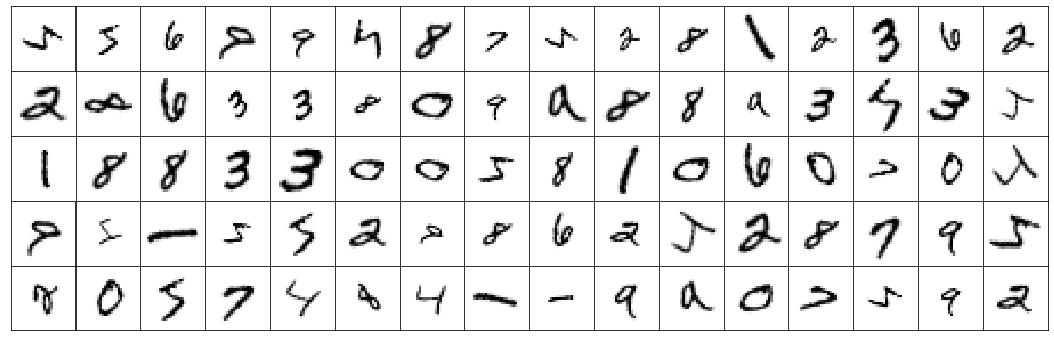

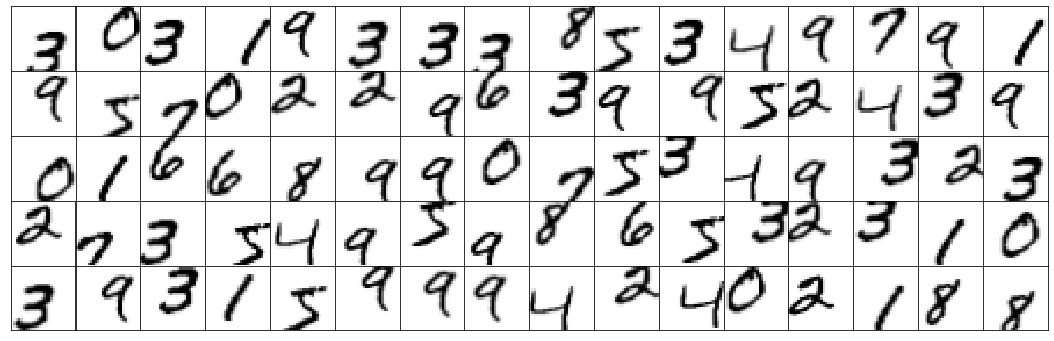

In [ ]:
B = 100
dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dr=[-75.0,75.0],ds=[0.5,1.0],cuda=True) # Rotation and Scaling
it = iter(dl)
y = next(it)
fig = plt.figure(figsize=(16,5))
for i in range(80):
    fig.add_subplot(5,16,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y[i].reshape(dim,dim).cpu().numpy(), cmap="Greys")
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.0,hspace=0.0)
# plt.tight_layout(h_pad=0.0,w_pad=0.0)
plt.show()
dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dx=[-0.25,0.25],dy=[-0.25,0.25],cuda=True) # Horizontal and Vertical Translation
it = iter(dl)
y = next(it)
fig = plt.figure(figsize=(16,5))
for i in range(80):
    fig.add_subplot(5,16,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y[i].reshape(dim,dim).cpu().numpy(), cmap="Greys")
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.0,hspace=0.0)
# plt.tight_layout(h_pad=0.0,w_pad=0.0)
plt.show()

# Training the network

In [ ]:
def create_w_learning_rate_adjuster(initial_lr, final_lr, warmup_steps):
    def adjust_w_learning_rate(optimizer, step):
        if step < warmup_steps:
            t = step / warmup_steps
            lr = (1-t)*initial_lr + t*final_lr
        else:
            lr = final_lr
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
    return adjust_w_learning_rate

def create_psi_learning_rate_adjuster(initial_lr, final_lr, warmup_steps):
    def adjust_psi_learning_rate(step):
        if step < warmup_steps:
            t = step / warmup_steps
            lr = (1-t)*initial_lr + t*final_lr
        else:
            lr = final_lr
        return lr
    
    return adjust_psi_learning_rate

**Initialization**

In [ ]:
B = 100

# Initialize dataloader
dl, test_dl, dim, D, num_train_batches, num_test_batches = get_MNIST_dataloader(B,cuda=True)
# dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dr=[-75.0,75.0],ds=[0.5,1.0],cuda=True) # Rotation and Scaling
# dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dx=[-0.25,0.25],dy=[-0.25,0.25],cuda=True) # Horizontal and Vertical Translation

# Initialize omega
# L = 128
# o_max = 9.5
# multiplicity = 1
# n = 2
L = 128
o_max = 6.5
multiplicity = 2
n = 2
omega = initialize_omega(n,L,o_max,multiplicity)
assert omega.size()[0] == L

# Initialize sparse coding dictionary
K = 100
psi = torch.rand(D,K).cuda() # (D,K)
psi = f.normalize(psi, dim=0)

# Initialize weights
pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
pre_w = lsc.orthogonalize(pre_w)
w_manifold = geoopt.manifolds.Stiefel()
w = geoopt.ManifoldParameter(pre_w,manifold=w_manifold,requires_grad=False)

# Initialize alpha
alpha_0 = 0.01
alpha = torch.ones(B,K).cuda()*alpha_0

k, m = None, None

epoch, T = 0, 0

**Parameters**

In [ ]:
# Tunable parameters
eta_psi = 0.05
eta_w = 0.3*10
warmup_epochs = 3
adjust_psi_learning_rate = create_psi_learning_rate_adjuster(0.0, eta_psi, warmup_epochs*num_train_batches)
adjust_w_learning_rate = create_w_learning_rate_adjuster(0.0, eta_w, warmup_epochs*num_train_batches)
w_optimizer = geoopt.optim.RiemannianAdam([w], lr=eta_w)
unique_omega = torch.unique(omega, dim=0) # (L,n)
s = 0.1
lamb = 1.0 # sparsity cost
lamb2 = 0.0 # slow feature cost 
lamb3 = 0.0 # psi regularization
epochs = 20 # 20000
save_skip = 100
steps = 20
N_samples = 100

# These options can be changed as needed.
test = True
save = True
annealing = False
shuffle = True
warmup = True

# The options below should not need to be changed.
adaptive = True
adaptive_steps = False
modified = False
video = False
map_est = False
rgb = False
plot = False



**File paths for saving data**

In [ ]:
# dataset_type = "rot_75_scale_0.5-1.0_"
# dataset_type = "ver_hor_"
dataset_type = ""
if adaptive_steps:
    new_dir = "data/{}MNIST{}x{}/s{}_B{}_K{}_n{}_omegax{}_lamb{}_L{}_epsi{}_ew{}_steps_adaptive_samples{}_initalpha{}".format(dataset_type,dim,dim,s,B,K,n,multiplicity,lamb,L,eta_psi,eta_w,N_samples,alpha_0)
else:
    new_dir = "data/{}MNIST{}x{}/s{}_B{}_K{}_n{}_omegax{}_lamb{}_L{}_epsi{}_ew{}_steps{}_samples{}_initalpha{}".format(dataset_type,dim,dim,s,B,K,n,multiplicity,lamb,L,eta_psi,eta_w,steps,N_samples,alpha_0)
if annealing:
    new_dir = new_dir + "_annealing"
else:
    new_dir = new_dir + "_no_annealing"
if shuffle:
    new_dir = new_dir + "_shuffle"
if warmup:
    new_dir = new_dir + f"_warmup{warmup_epochs}"
new_dir = new_dir + "_5"
"""if save:
    if not os.path.isdir("data/{}MNIST{}x{}".format(dataset_type,dim,dim)):
        os.mkdir("data/{}MNIST{}x{}".format(dataset_type,dim,dim))
    os.mkdir(new_dir)
    os.mkdir(new_dir + "/data")
    os.mkdir(new_dir + "/figures")
    os.mkdir(new_dir + "/videos")"""
data_path = new_dir + "/data/{}_epoch_{}.txt"
fig_path = new_dir + "/figures/{}_epoch_{}.png"
video_path = new_dir + "/videos/{}_epoch_{}_batch_{}.mp4"

In [ ]:
psi

tensor([[0.0104, 0.0151, 0.0206,  ..., 0.0600, 0.0301, 0.0340],
        [0.0360, 0.0238, 0.0132,  ..., 0.0272, 0.0203, 0.0028],
        [0.0577, 0.0085, 0.0295,  ..., 0.0395, 0.0463, 0.0125],
        ...,
        [0.0430, 0.0056, 0.0141,  ..., 0.0331, 0.0022, 0.0200],
        [0.0468, 0.0018, 0.0556,  ..., 0.0150, 0.0399, 0.0545],
        [0.0070, 0.0536, 0.0497,  ..., 0.0445, 0.0420, 0.0502]],
       device='cuda:0')

In [ ]:
shuffle=False
alpha_all = torch.rand(dl.size(0),B,K).cuda()*.0001
s_all = torch.rand(dl.size(0),B,2).cuda()*.001
pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
#pre_w = lsc.orthogonalize(pre_w)
w = pre_w*.001
w.requires_grad=True
psi = torch.rand(D,K).cuda()*.0001 # (D,K)
#psi = f.normalize(psi, dim=0)
psi.requires_grad=True
alpha_all.requires_grad=True
s_all.requires_grad=True
torch_loss_fn = torch.nn.MSELoss()
model_optimizer=torch.optim.Adam([alpha_all, s_all, psi, w], lr=.0007)

In [ ]:
#down to e-5 epoch 106 with normalizing psi during training (did not ortho during training)
shuffle=False
alpha_all = torch.rand(dl.size(0),B,K).cuda()*.0001
alpha_all = torch.nn.init.xavier_uniform_(alpha_all)
s_all = torch.rand(dl.size(0),B,2).cuda()*.001
s_all = torch.nn.init.xavier_uniform_(s_all)

pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
#pre_w = lsc.orthogonalize(pre_w)
w = pre_w*.001
w = torch.nn.init.xavier_uniform_(w)
w = lsc.orthogonalize(w)

w.requires_grad=True
psi = torch.rand(D,K).cuda()*.0001 # (D,K)
psi = torch.nn.init.xavier_uniform_(psi)

#psi = f.normalize(psi, dim=0)
psi.requires_grad=True
alpha_all.requires_grad=True
s_all.requires_grad=True
torch_loss_fn = torch.nn.MSELoss()
model_optimizer=torch.optim.Adam([alpha_all, s_all, psi, w], lr=.0002)

In [ ]:
epoch=0
while epoch < 5000:    
    # Training
    losses=[]
    T=0
    while T < num_train_batches:
        #while T<5:
        y = dl[T]

        alpha_batch = alpha_all[T]
        s_batch = s_all[T]
        x = torch.einsum('dk,bk->bd',psi,alpha_batch) # (B,D)
        out = lsc.reconstruct(x,w,s_batch,omega)
        total_loss = torch_loss_fn(out,y)
        model_optimizer.zero_grad()
        total_loss.backward()
        model_optimizer.step()
        with torch.no_grad():
            psi = f.normalize(psi,dim=0)
        
        losses.append(total_loss.item())
        T+=1
        #print(total_loss.item())
    print(epoch,'mean loss',np.mean(losses))
    epoch+=1

0 mean loss 0.0012762661590628947
1 mean loss 0.0008627148773909236
2 mean loss 0.0007786734653442788
3 mean loss 0.0006080197038439413
4 mean loss 0.0005010315993664941
5 mean loss 0.0004595027210113282
6 mean loss 0.00044068048509264676
7 mean loss 0.0004157992179777163
8 mean loss 0.0003981676524078163
9 mean loss 0.0003693616941745859
10 mean loss 0.0003808261601564785
11 mean loss 0.00035605342888932987
12 mean loss 0.0003398758138064295
13 mean loss 0.000332033596932888
14 mean loss 0.0003281822765226631
15 mean loss 0.0003060079098213464
16 mean loss 0.0002827039394469466
17 mean loss 0.00027784447547067733
18 mean loss 0.0002766816587245557
19 mean loss 0.00027623041280700513
20 mean loss 0.0002677266017174891
21 mean loss 0.00025251880460321746
22 mean loss 0.00024284040521403463
23 mean loss 0.0002306115113121147
24 mean loss 0.0002233596283379787
25 mean loss 0.00021621864829891516
26 mean loss 0.00020921725415973925
27 mean loss 0.00020372858552339797
28 mean loss 0.0002044

KeyboardInterrupt: 

In [ ]:
# e-5 by epoch 70. fixed problem no psi update. 
class Model(nn.Module):
    def __init__(self,D,L):
        super(Model,self).__init__()
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        self.w = torch.nn.init.xavier_uniform_(w)
        self.w.requires_grad=True
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        self.psi = torch.nn.init.xavier_uniform_(psi)
        self.psi.requires_grad=True
    
    def forward(self,alpha_batch,s_batch):
        with torch.no_grad():
            self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        x = torch.einsum('dk,bk->bd',self.psi,alpha_batch) # (B,D)
        out = lsc.reconstruct(x,self.w,s_batch,omega)
        return out

model=Model(D,L)
shuffle=False
alpha_all = torch.rand(dl.size(0),B,K).cuda()*.0001
alpha_all = torch.nn.init.xavier_uniform_(alpha_all)
s_all = torch.rand(dl.size(0),B,2).cuda()*.001
s_all = torch.nn.init.xavier_uniform_(s_all)
alpha_all.requires_grad=True
s_all.requires_grad=True

torch_loss_fn = torch.nn.MSELoss()
model_optimizer=torch.optim.Adam([alpha_all, s_all, model.w, model.psi], lr=.0002)

In [ ]:
epoch=0 #lr .0002
while epoch < 5000:    
    # Training
    losses=[]
    T=0
    while T < num_train_batches:
        #while T<1:
        #with torch.no_grad():
        #    print(model.psi[0])
        y = dl[T]

        alpha_batch = alpha_all[T]
        s_batch = s_all[T]
        #x = torch.einsum('dk,bk->bd',psi,alpha_batch) # (B,D)
        #out = lsc.reconstruct(x,w,s_batch,omega)
        out = model(alpha_batch,s_batch)
        total_loss = torch_loss_fn(out,y)
        model_optimizer.zero_grad()
        total_loss.backward()
        model_optimizer.step()
        
        
        losses.append(total_loss.item())
        T+=1
        #print(total_loss.item())
    print(epoch,'mean loss',np.mean(losses))
    epoch+=1

0 mean loss 0.0012768462230451404
1 mean loss 0.0007974183824262581
2 mean loss 0.0007768303096721259
3 mean loss 0.0005812277067646695
4 mean loss 0.0004853813582546233
5 mean loss 0.00044460708517969275
6 mean loss 0.00041326635580238264
7 mean loss 0.00038948542258973855
8 mean loss 0.00037486249217181465
9 mean loss 0.00034851292458673317
10 mean loss 0.00033199960710286785
11 mean loss 0.00031735388562083246
12 mean loss 0.00030214487972746916
13 mean loss 0.0002864100821898319
14 mean loss 0.00027677413716446607
15 mean loss 0.0002683659066193892
16 mean loss 0.00025499550460760174
17 mean loss 0.0002463056773558492
18 mean loss 0.00024369106414572647
19 mean loss 0.0002386472288829585
20 mean loss 0.00023301269985192145
21 mean loss 0.00022518094878857178
22 mean loss 0.00020883978674343477
23 mean loss 0.000200392965368034
24 mean loss 0.0001932215895067202
25 mean loss 0.00019140163700891814
26 mean loss 0.00018928899356978945
27 mean loss 0.00018388447584584357
28 mean loss 0

KeyboardInterrupt: 

In [ ]:
# e-5 in epoch 35. Test loss - 24.155; SNR - 4.143; L1 - 3.360. normalization and ortho
class Model(nn.Module):
    def __init__(self,D,L):
        super(Model,self).__init__()
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        #self.w.requires_grad=True
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        #self.psi.requires_grad=True
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
    
    def forward(self,alpha_batch,s_batch):
        with torch.no_grad():
            self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        x = torch.einsum('dk,bk->bd',self.psi,alpha_batch) # (B,D)
        out = lsc.reconstruct(x,self.w,s_batch,omega)
        return out

model=Model(D,L)
geotorch.orthogonal(model,"w")
shuffle=False
alpha_all = torch.rand(dl.size(0),B,K).cuda()*.0001
alpha_all = torch.nn.init.xavier_uniform_(alpha_all)
s_all = torch.rand(dl.size(0),B,2).cuda()*.001
s_all = torch.nn.init.xavier_uniform_(s_all)
alpha_all.requires_grad=True
s_all.requires_grad=True

torch_loss_fn = torch.nn.MSELoss()
model_optimizer=torch.optim.Adam([alpha_all, s_all]+list(model.parameters()), lr=.0002)

epoch=0 #lr .0002
while epoch < 5000:    
    # Training
    losses=[]
    T=0
    while T < num_train_batches:
        #while T<1:
        #with torch.no_grad():
        #    print(model.psi[0])
        y = dl[T]

        alpha_batch = alpha_all[T]
        s_batch = s_all[T]
        #x = torch.einsum('dk,bk->bd',psi,alpha_batch) # (B,D)
        #out = lsc.reconstruct(x,w,s_batch,omega)
        out = model(alpha_batch,s_batch)
        total_loss = torch_loss_fn(out,y)
        model_optimizer.zero_grad()
        total_loss.backward()
        model_optimizer.step()
        
        
        losses.append(total_loss.item())
        T+=1
        #print(total_loss.item())
    print(epoch,'mean loss',np.mean(losses))
    epoch+=1

0 mean loss 0.001276385928116118
1 mean loss 0.0011276081481870885
2 mean loss 0.0008469926819088869
3 mean loss 0.0007211072605180865
4 mean loss 0.0006695051921027092
5 mean loss 0.000615871142654214
6 mean loss 0.0005641617749157983
7 mean loss 0.0005174664877995383
8 mean loss 0.00047537330402216564
9 mean loss 0.0004371192681234485
10 mean loss 0.0004021530183672439
11 mean loss 0.0003702385136663603
12 mean loss 0.00034108027747909846
13 mean loss 0.00031445006796275264
14 mean loss 0.00029015403963664237
15 mean loss 0.00026805658807764607
16 mean loss 0.00024804947373922913
17 mean loss 0.0002299879805650562
18 mean loss 0.00021373635805503
19 mean loss 0.00019918286787287798
20 mean loss 0.00018631890450099793
21 mean loss 0.00017529719751716282
22 mean loss 0.0001662606463408641
23 mean loss 0.00015883288336529706
24 mean loss 0.0001519408380894068
25 mean loss 0.00014498205768177287
26 mean loss 0.00013829304535950844
27 mean loss 0.00013197892548002225
28 mean loss 0.000126

KeyboardInterrupt: 

In [ ]:
# .00016 in epoch 200, l1.000001 Test loss - 17.638; SNR - 7.957; L1 - 2.525

# Model stores w and psi parameters. takes input alpha, s and multiplies with w,psi to get output
class Model(nn.Module):
    def __init__(self,D,L):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
    
    # this computes the model output given alpha and s
    def forward(self,alpha_batch,s_batch):
        with torch.no_grad():
            self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        x = torch.einsum('dk,bk->bd',self.psi,alpha_batch) # (B,D)
        out = lsc.reconstruct(x,self.w,s_batch,omega)
        return out

# create model
model=Model(D,L)
# this line makes it so that the w parameter stays orthogonal
geotorch.orthogonal(model,"w")
shuffle=False
# initialize alpha and s
alpha_all = torch.rand(dl.size(0),B,K).cuda()*.0001
alpha_all = torch.nn.init.xavier_uniform_(alpha_all)
s_all = torch.rand(dl.size(0),B,2).cuda()*.001
s_all = torch.nn.init.xavier_uniform_(s_all)
alpha_all.requires_grad=True
s_all.requires_grad=True

# loss function is mean squared error and optimizer is Adam
torch_loss_fn = torch.nn.MSELoss()
model_optimizer=torch.optim.Adam([alpha_all, s_all]+list(model.parameters()), lr=.0002)

# this is the training loop
# in each epoch, go through all of the training data once
epoch=0 #lr .0002
while epoch < 5000:    
    losses=[]
    T=0
    # we process the training data in batches of size 100
    while T < num_train_batches:
        # get the target value, y, and alpha and s for the batch
        y = dl[T]
        alpha_batch = alpha_all[T]
        s_batch = s_all[T]
        # get model output for the alpha and s
        out = model(alpha_batch,s_batch)
        # loss is sum of prediction loss (MSE) and l1 loss on alpha
        # multiply the l1 norm of alpha by small constant
        l1_reg = .000001 * torch.norm(alpha_batch, 1)
        pred_loss = torch_loss_fn(out,y)
        total_loss = pred_loss+l1_reg
        # zero past gradients, the backward to get new gradients, then optimizer step
        model_optimizer.zero_grad()
        total_loss.backward()
        model_optimizer.step()
        
        
        losses.append(pred_loss.item())
        T+=1
    print(epoch,'mean loss',np.mean(losses))
    epoch+=1

0 mean loss 0.00127639328110187
1 mean loss 0.0011877088450516263
2 mean loss 0.0008745205682741167
3 mean loss 0.0007391391200750756
4 mean loss 0.0007022347298334353
5 mean loss 0.000655359965749085
6 mean loss 0.000611001126235351
7 mean loss 0.0005684952464071102
8 mean loss 0.0005310864298371598
9 mean loss 0.0004967288618111827
10 mean loss 0.0004668055885122158
11 mean loss 0.0004406888148514554
12 mean loss 0.00041761660962947645
13 mean loss 0.0003977184083487373
14 mean loss 0.00037964565330184997
15 mean loss 0.0003640670592236954
16 mean loss 0.00034938922690344045
17 mean loss 0.00033682973128937495
18 mean loss 0.00032477055069951653
19 mean loss 0.0003145905647155208
20 mean loss 0.00030457161425147207
21 mean loss 0.0002962434447060029
22 mean loss 0.00028776576902600937
23 mean loss 0.0002808632507124761
24 mean loss 0.0002735960890034524
25 mean loss 0.0002678411145704255
26 mean loss 0.0002615658188733505
27 mean loss 0.00025674759376367244
28 mean loss 0.00025128806

KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    # Validation
    print('testing')
    test_it = iter(test_dl)
    test_loss = 0.0
    test_snr = 0.0
    test_l1 = 0.0
    #normed_psi = f.normalize(psi,dim=0)
    T=0
    while T < num_test_batches:
        # Generate data was here before
        y = next(test_it)

        # Optimize alpha
        alpha[...] = alpha_0
        alpha = lsc.alpha_update_FISTA(y, model.psi, model.w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=False, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

        # Calculate useful variables. started here before
        x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, model.psi, model.w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

        # Calculate error
        test_loss += -lsc.log_likelihood(x, y, u, v, model.psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
        post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
        s_hat = utils.get_MAP(post) #started here before
        recon = lsc.reconstruct(x, model.w, s_hat, omega)
        test_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
        test_l1 += alpha.norm(dim=1, p=1).mean()
        T += 1

    test_loss /= num_test_batches
    test_snr /= num_test_batches
    test_l1 /= num_test_batches
    T = 0
    print("Epoch {}: Test loss - {:.3f}; SNR - {:.3f}; L1 - {:.3f}; ".format(epoch, test_loss, test_snr, test_l1))


testing
Epoch 119: Test loss - 19.064; SNR - 6.746; L1 - 2.259; 


In [ ]:
# 
class Model(nn.Module):
    def __init__(self,D,L):
        super(Model,self).__init__()
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        #self.w.requires_grad=True
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        #self.psi.requires_grad=True
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
    
    def forward(self,alpha_batch,s_batch):
        with torch.no_grad():
            self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        x = torch.einsum('dk,bk->bd',self.psi,alpha_batch) # (B,D)
        out = lsc.reconstruct(x,self.w,s_batch,omega)
        return out

regs = [.000005,.000002,.0000008,.0000003]
for reg in regs:
    model=Model(D,L)
    geotorch.orthogonal(model,"w")
    shuffle=False
    alpha_all = torch.rand(dl.size(0),B,K).cuda()*.0001
    alpha_all = torch.nn.init.xavier_uniform_(alpha_all)
    s_all = torch.rand(dl.size(0),B,2).cuda()*.001
    s_all = torch.nn.init.xavier_uniform_(s_all)
    alpha_all.requires_grad=True
    s_all.requires_grad=True

    torch_loss_fn = torch.nn.MSELoss()
    model_optimizer=torch.optim.Adam([alpha_all, s_all]+list(model.parameters()), lr=.0002)

    epoch=0 #lr .0002
    while epoch < 250:    
        # Training
        losses=[]
        T=0
        while T < num_train_batches:
            #while T<1:
            y = dl[T]

            alpha_batch = alpha_all[T]
            s_batch = s_all[T]
            out = model(alpha_batch,s_batch)
            l1_reg = reg * torch.norm(alpha_batch, 1)
            pred_loss = torch_loss_fn(out,y)
            total_loss = pred_loss+l1_reg
            model_optimizer.zero_grad()
            total_loss.backward()
            model_optimizer.step()


            losses.append(pred_loss.item())
            T+=1
            #print(total_loss.item())
        if (epoch+1)%50==0: print(epoch,'mean loss',np.mean(losses))
        epoch+=1
    with torch.no_grad():
        # Validation
        print('testing',reg)
        test_it = iter(test_dl)
        test_loss = 0.0
        test_snr = 0.0
        test_l1 = 0.0
        #normed_psi = f.normalize(psi,dim=0)
        T=0
        while T < num_test_batches:
            # Generate data was here before
            y = next(test_it)

            # Optimize alpha
            alpha[...] = alpha_0
            alpha = lsc.alpha_update_FISTA(y, model.psi, model.w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=False, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

            # Calculate useful variables. started here before
            x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, model.psi, model.w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

            # Calculate error
            test_loss += -lsc.log_likelihood(x, y, u, v, model.psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
            post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
            s_hat = utils.get_MAP(post) #started here before
            recon = lsc.reconstruct(x, model.w, s_hat, omega)
            test_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
            test_l1 += alpha.norm(dim=1, p=1).mean()
            T += 1

        test_loss /= num_test_batches
        test_snr /= num_test_batches
        test_l1 /= num_test_batches
        T = 0
        print("Epoch {}: Test loss - {:.3f}; SNR - {:.3f}; L1 - {:.3f}; ".format(epoch, test_loss, test_snr, test_l1))


49 mean loss 0.0005230244666260356
99 mean loss 0.00041649397258879616
149 mean loss 0.00037723684101365507
199 mean loss 0.0003589928375246624
249 mean loss 0.00034817176099750214
testing 5e-06


/home/eric/Documents/Lie_sparse_coding/lsc.py:210: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2488.)
  lipschitz = 1.5*torch.max(torch.symeig(torch.mm(wpsi.t(),wpsi),eigenvectors=False)[0])/sigma**2


Epoch 250: Test loss - 21.712; SNR - 4.856; L1 - 1.690; 
49 mean loss 0.00028908378391255004
99 mean loss 0.00025453667619634266
149 mean loss 0.0002442418951007615
199 mean loss 0.00023307570476996866
249 mean loss 0.0002273492032206074
testing 2e-06
Epoch 250: Test loss - 19.079; SNR - 6.485; L1 - 2.044; 
49 mean loss 0.00017596587795803013
99 mean loss 0.00015169080271637843
149 mean loss 0.00014592240848287474
199 mean loss 0.00014313289218989667
249 mean loss 0.00014147138521366286
testing 8e-07
Epoch 250: Test loss - 18.607; SNR - 6.990; L1 - 2.498; 
49 mean loss 0.00010439098047451504
99 mean loss 8.507431607237474e-05
149 mean loss 8.17699260005611e-05
199 mean loss 8.0846981521366e-05
249 mean loss 8.067763012756283e-05
testing 3e-07
Epoch 250: Test loss - 20.342; SNR - 5.794; L1 - 2.877; 


In [ ]:
# Model stores w and psi parameters. takes input alpha, s and multiplies with w,psi to get output
class Model(nn.Module):
    def __init__(self,D,L):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
    
    # this computes the model output given alpha and s
    def forward(self,alpha_batch,s_batch):
        with torch.no_grad():
            self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        x = torch.einsum('dk,bk->bd',self.psi,alpha_batch) # (B,D)
        out = lsc.reconstruct(x,self.w,s_batch,omega)
        return out

reg = 8e-07
lrs = [.0008,.0001,.00003]
for lr in lrs:
    model=Model(D,L)
    geotorch.orthogonal(model,"w")
    shuffle=False
    alpha_all = torch.rand(dl.size(0),B,K).cuda()*.0001
    alpha_all = torch.nn.init.xavier_uniform_(alpha_all)
    s_all = torch.rand(dl.size(0),B,2).cuda()*.001
    s_all = torch.nn.init.xavier_uniform_(s_all)
    alpha_all.requires_grad=True
    s_all.requires_grad=True

    torch_loss_fn = torch.nn.MSELoss()
    model_optimizer=torch.optim.Adam([alpha_all, s_all]+list(model.parameters()), lr=lr)

    epoch=0 #lr .0002
    while epoch < 250:    
        # Training
        losses=[]
        T=0
        while T < num_train_batches:
            #while T<1:
            y = dl[T]

            alpha_batch = alpha_all[T]
            s_batch = s_all[T]
            out = model(alpha_batch,s_batch)
            l1_reg = reg * torch.norm(alpha_batch, 1)
            pred_loss = torch_loss_fn(out,y)
            total_loss = pred_loss+l1_reg
            model_optimizer.zero_grad()
            total_loss.backward()
            model_optimizer.step()


            losses.append(pred_loss.item())
            T+=1
            #print(total_loss.item())
        if (epoch+1)%50==0: print(epoch,'mean loss',np.mean(losses))
        epoch+=1
    with torch.no_grad():
        # Validation
        print('testing',reg)
        test_it = iter(test_dl)
        test_loss = 0.0
        test_snr = 0.0
        test_l1 = 0.0
        #normed_psi = f.normalize(psi,dim=0)
        T=0
        while T < num_test_batches:
            # Generate data was here before
            y = next(test_it)

            # Optimize alpha
            alpha[...] = alpha_0
            alpha = lsc.alpha_update_FISTA(y, model.psi, model.w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=False, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

            # Calculate useful variables. started here before
            x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, model.psi, model.w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

            # Calculate error
            test_loss += -lsc.log_likelihood(x, y, u, v, model.psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
            post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
            s_hat = utils.get_MAP(post) #started here before
            recon = lsc.reconstruct(x, model.w, s_hat, omega)
            test_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
            test_l1 += alpha.norm(dim=1, p=1).mean()
            T += 1

        test_loss /= num_test_batches
        test_snr /= num_test_batches
        test_l1 /= num_test_batches
        T = 0
        print("Epoch {}: Test loss - {:.3f}; SNR - {:.3f}; L1 - {:.3f}; ".format(epoch, test_loss, test_snr, test_l1))


49 mean loss 0.00017152108720135098
99 mean loss 0.00015851920489997912
149 mean loss 0.00015348619196932608
199 mean loss 0.00014981795672307878
249 mean loss 0.0001481891882091683
testing 8e-07
Epoch 250: Test loss - 20.325; SNR - 5.930; L1 - 2.938; 
49 mean loss 0.00021798770717092945
99 mean loss 0.0001604037930277021
149 mean loss 0.00014933462104333255
199 mean loss 0.00014525670643100359
249 mean loss 0.00014300561898077528
testing 8e-07
Epoch 250: Test loss - 18.452; SNR - 7.439; L1 - 2.782; 
49 mean loss 0.0004754254885968597
99 mean loss 0.000297247959873251
149 mean loss 0.00022520916851741883
199 mean loss 0.00019066662964178249
249 mean loss 0.00017237037788921347
testing 8e-07
Epoch 250: Test loss - 36.613; SNR - 2.324; L1 - 2.981; 


In [ ]:
# Model stores w and psi parameters. takes input alpha, s and multiplies with w,psi to get output
class Model(nn.Module):
    def __init__(self,D,L):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
    
    # this computes the model output given alpha and s
    def forward(self,alpha_batch,s_batch):
        with torch.no_grad():
            self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        x = torch.einsum('dk,bk->bd',self.psi,alpha_batch) # (B,D)
        out = lsc.reconstruct(x,self.w,s_batch,omega)
        return out

regs = [.0000015,.000001, 8e-7]
lrs = [.0005,.0002,.00007]
for lr in lrs:
    for reg in regs:
        if reg==.0000015 and lr==.0005: continue
        model=Model(D,L)
        geotorch.orthogonal(model,"w")
        shuffle=False
        alpha_all = torch.rand(dl.size(0),B,K).cuda()*.0001
        alpha_all = torch.nn.init.xavier_uniform_(alpha_all)
        s_all = torch.rand(dl.size(0),B,2).cuda()*.001
        s_all = torch.nn.init.xavier_uniform_(s_all)
        alpha_all.requires_grad=True
        s_all.requires_grad=True

        torch_loss_fn = torch.nn.MSELoss()
        model_optimizer=torch.optim.Adam([alpha_all, s_all]+list(model.parameters()), lr=lr)

        epoch=0 #lr .0002
        while epoch < 250:    
            # Training
            losses=[]
            torch_test_losses=[]
            T=0
            while T < num_train_batches:
                #while T<1:
                y = dl[T]

                alpha_batch = alpha_all[T]
                s_batch = s_all[T]
                out = model(alpha_batch,s_batch)
                l1_reg = reg * torch.norm(alpha_batch, 1)
                pred_loss = torch_loss_fn(out,y)
                total_loss = pred_loss+l1_reg
                model_optimizer.zero_grad()
                total_loss.backward()
                model_optimizer.step()


                losses.append(pred_loss.item())
                T+=1
                #print(total_loss.item())
            if (epoch+1)%50==0: print(epoch,'mean loss',np.mean(losses))
            epoch+=1
        with torch.no_grad():
            # Validation
            print('testing','reg',reg,'lr',lr)
            test_it = iter(test_dl)
            test_loss = 0.0
            test_snr = 0.0
            test_l1 = 0.0
            #normed_psi = f.normalize(psi,dim=0)
            T=0
            while T < num_test_batches:
                # Generate data was here before
                y = next(test_it)

                # Optimize alpha
                alpha[...] = alpha_0
                alpha = lsc.alpha_update_FISTA(y, model.psi, model.w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=False, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

                # Calculate useful variables. started here before
                x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, model.psi, model.w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

                # Calculate error
                test_loss += -lsc.log_likelihood(x, y, u, v, model.psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
                post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
                s_hat = utils.get_MAP(post) #started here before
                recon = lsc.reconstruct(x, model.w, s_hat, omega)
                torch_test_loss = torch_loss_fn(recon,y)
                torch_test_losses.append(torch_test_loss.item())
                test_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
                test_l1 += alpha.norm(dim=1, p=1).mean()
                T += 1

            test_loss /= num_test_batches
            test_snr /= num_test_batches
            test_l1 /= num_test_batches
            T = 0
            print("Epoch {}: Test loss - {:.3f}; SNR - {:.3f}; L1 - {:.3f}; ".format(epoch, test_loss, test_snr, test_l1))
            print(epoch,'mean test torch loss',np.mean(torch_test_losses))

49 mean loss 0.00018834886298767136
99 mean loss 0.0001742073274848129
149 mean loss 0.00017952575789725717
199 mean loss 0.00016774159446261667
249 mean loss 0.00016223361332473967
testing reg 1e-06 lr 0.0005
Epoch 250: Test loss - 18.403; SNR - 7.341; L1 - 2.594; 
250 mean test torch loss 0.00020021246993565
49 mean loss 0.00016873253628242916
99 mean loss 0.00015603708913355756
149 mean loss 0.00015300088690613242
199 mean loss 0.00015490678672601158
249 mean loss 0.00015014146180571212
testing reg 8e-07 lr 0.0005
Epoch 250: Test loss - 20.094; SNR - 6.013; L1 - 2.586; 
250 mean test torch loss 0.0002457827269972768
49 mean loss 0.00024973854701480986
99 mean loss 0.00021613044358673506
149 mean loss 0.00020741020052810198
199 mean loss 0.00020416153745221285
249 mean loss 0.00020396171101310756
testing reg 1.5e-06 lr 0.0002
Epoch 250: Test loss - 19.883; SNR - 6.245; L1 - 2.320; 
250 mean test torch loss 0.0002520966366864741
49 mean loss 0.00020079017854489697
99 mean loss 0.00017

KeyboardInterrupt: 

In [ ]:
# Model stores w and psi parameters. takes input alpha, s and multiplies with w,psi to get output
class Model(nn.Module):
    def __init__(self,D,L):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
    
    # this computes the model output given alpha and s
    def forward(self,alpha_batch,s_batch):
        with torch.no_grad():
            self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        x = torch.einsum('dk,bk->bd',self.psi,alpha_batch) # (B,D)
        out = lsc.reconstruct(x,self.w,s_batch,omega)
        return out

regs = [.0000015,.000001, 8e-7]
lrs = [.0002,.00007]
for lr in lrs:
    for reg in regs:
        if lr==.0002:
            if reg==.0000015 or reg==.000001: continue
        model=Model(D,L)
        geotorch.orthogonal(model,"w")
        shuffle=False
        alpha_all = torch.rand(dl.size(0),B,K).cuda()*.0001
        alpha_all = torch.nn.init.xavier_uniform_(alpha_all)
        s_all = torch.rand(dl.size(0),B,2).cuda()*.001
        s_all = torch.nn.init.xavier_uniform_(s_all)
        alpha_all.requires_grad=True
        s_all.requires_grad=True

        torch_loss_fn = torch.nn.MSELoss()
        model_optimizer=torch.optim.Adam([alpha_all, s_all]+list(model.parameters()), lr=lr)

        epoch=0 #lr .0002
        while epoch < 250:    
            # Training
            losses=[]
            torch_test_losses=[]
            T=0
            while T < num_train_batches:
                #while T<1:
                y = dl[T]

                alpha_batch = alpha_all[T]
                s_batch = s_all[T]
                out = model(alpha_batch,s_batch)
                l1_reg = reg * torch.norm(alpha_batch, 1)
                pred_loss = torch_loss_fn(out,y)
                total_loss = pred_loss+l1_reg
                model_optimizer.zero_grad()
                total_loss.backward()
                model_optimizer.step()


                losses.append(pred_loss.item())
                T+=1
                #print(total_loss.item())
            if (epoch+1)%50==0: print(epoch,'mean loss',np.mean(losses))
            epoch+=1
        with torch.no_grad():
            # Validation
            print('testing','reg',reg,'lr',lr)
            test_it = iter(test_dl)
            test_loss = 0.0
            test_snr = 0.0
            test_l1 = 0.0
            #normed_psi = f.normalize(psi,dim=0)
            T=0
            while T < num_test_batches:
                # Generate data was here before
                y = next(test_it)

                # Optimize alpha
                alpha[...] = alpha_0
                alpha = lsc.alpha_update_FISTA(y, model.psi, model.w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=False, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

                # Calculate useful variables. started here before
                x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, model.psi, model.w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

                # Calculate error
                test_loss += -lsc.log_likelihood(x, y, u, v, model.psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
                post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
                s_hat = utils.get_MAP(post) #started here before
                recon = lsc.reconstruct(x, model.w, s_hat, omega)
                torch_test_loss = torch_loss_fn(recon,y)
                torch_test_losses.append(torch_test_loss.item())
                test_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
                test_l1 += alpha.norm(dim=1, p=1).mean()
                T += 1

            test_loss /= num_test_batches
            test_snr /= num_test_batches
            test_l1 /= num_test_batches
            T = 0
            print("Epoch {}: Test loss - {:.3f}; SNR - {:.3f}; L1 - {:.3f}; ".format(epoch, test_loss, test_snr, test_l1))
            print(epoch,'mean test torch loss',np.mean(torch_test_losses))

49 mean loss 0.00017599144846220345
99 mean loss 0.0001530602039808097
149 mean loss 0.00014753603507415393
199 mean loss 0.0001449925490548291
249 mean loss 0.0001433074354281416
testing reg 8e-07 lr 0.0002


/home/eric/Documents/Lie_sparse_coding/lsc.py:210: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2488.)
  lipschitz = 1.5*torch.max(torch.symeig(torch.mm(wpsi.t(),wpsi),eigenvectors=False)[0])/sigma**2


Epoch 250: Test loss - 18.698; SNR - 6.909; L1 - 2.609; 
250 mean test torch loss 0.00021362787374528124
49 mean loss 0.00034580915666689786
99 mean loss 0.0002527533581693812
149 mean loss 0.00022440104320897564
199 mean loss 0.00021309553742563972
249 mean loss 0.00020763269317588615
testing reg 1.5e-06 lr 7e-05
Epoch 250: Test loss - 20.096; SNR - 6.121; L1 - 2.297; 
250 mean test torch loss 0.00024837866687448695
49 mean loss 0.00029748111812902305
99 mean loss 0.00020308802100771573
149 mean loss 0.00017899435256064558
199 mean loss 0.0001701370725883559
249 mean loss 0.00016580690993578173
testing reg 1e-06 lr 7e-05
Epoch 250: Test loss - 18.607; SNR - 7.163; L1 - 2.469; 
250 mean test torch loss 0.0002053722298296634
49 mean loss 0.0002741411401560375
99 mean loss 0.00017964570979529527
149 mean loss 0.00015740160277346148
199 mean loss 0.00014969139500559928
249 mean loss 0.00014594993260592067
testing reg 8e-07 lr 7e-05
Epoch 250: Test loss - 19.534; SNR - 6.359; L1 - 2.591; 


In [ ]:
# Model stores w and psi parameters. takes input alpha, s and multiplies with w,psi to get output
class Model(nn.Module):
    def __init__(self,D,L):
        super(Model,self).__init__()
        # this initializes parameters
        pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
        w = pre_w*.001
        w = torch.nn.init.xavier_uniform_(w)
        self.w = nn.Parameter(w, requires_grad=True).cuda()
        psi = torch.rand(D,K).cuda()*.0001 # (D,K)
        psi = torch.nn.init.xavier_uniform_(psi)
        self.psi = nn.Parameter(psi,requires_grad=True).cuda()
    
    # this computes the model output given alpha and s
    def forward(self,alpha_batch,s_batch):
        with torch.no_grad():
            self.psi += f.normalize(self.psi,dim=0)-self.psi # TODO change this
        x = torch.einsum('dk,bk->bd',self.psi,alpha_batch) # (B,D)
        out = lsc.reconstruct(x,self.w,s_batch,omega)
        return out

regs = [.0000006,.0000003, .0000001]
lrs = [.0002,.00012]
for lr in lrs:
    for reg in regs:
        model=Model(D,L)
        geotorch.orthogonal(model,"w")
        shuffle=False
        alpha_all = torch.rand(dl.size(0),B,K).cuda()*.0001
        alpha_all = torch.nn.init.xavier_uniform_(alpha_all)
        s_all = torch.rand(dl.size(0),B,2).cuda()*.001
        s_all = torch.nn.init.xavier_uniform_(s_all)
        alpha_all.requires_grad=True
        s_all.requires_grad=True

        torch_loss_fn = torch.nn.MSELoss()
        model_optimizer=torch.optim.Adam([alpha_all, s_all]+list(model.parameters()), lr=lr)

        epoch=0 #lr .0002
        while epoch < 250:    
            # Training
            losses=[]
            torch_test_losses=[]
            T=0
            while T < num_train_batches:
                #while T<1:
                y = dl[T]

                alpha_batch = alpha_all[T]
                s_batch = s_all[T]
                out = model(alpha_batch,s_batch)
                l1_reg = reg * torch.norm(alpha_batch, 1)
                pred_loss = torch_loss_fn(out,y)
                total_loss = pred_loss+l1_reg
                model_optimizer.zero_grad()
                total_loss.backward()
                model_optimizer.step()


                losses.append(pred_loss.item())
                T+=1
                #print(total_loss.item())
            if (epoch+1)%50==0: print(epoch,'mean loss',np.mean(losses))
            epoch+=1
        with torch.no_grad():
            # Validation
            print('testing','reg',reg,'lr',lr)
            test_it = iter(test_dl)
            test_loss = 0.0
            test_snr = 0.0
            test_l1 = 0.0
            #normed_psi = f.normalize(psi,dim=0)
            T=0
            while T < num_test_batches:
                # Generate data was here before
                y = next(test_it)

                # Optimize alpha
                alpha[...] = alpha_0
                alpha = lsc.alpha_update_FISTA(y, model.psi, model.w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=False, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

                # Calculate useful variables. started here before
                x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, model.psi, model.w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

                # Calculate error
                test_loss += -lsc.log_likelihood(x, y, u, v, model.psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
                post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
                s_hat = utils.get_MAP(post) #started here before
                recon = lsc.reconstruct(x, model.w, s_hat, omega)
                torch_test_loss = torch_loss_fn(recon,y)
                torch_test_losses.append(torch_test_loss.item())
                test_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
                test_l1 += alpha.norm(dim=1, p=1).mean()
                T += 1

            test_loss /= num_test_batches
            test_snr /= num_test_batches
            test_l1 /= num_test_batches
            T = 0
            print("Epoch {}: Test loss - {:.3f}; SNR - {:.3f}; L1 - {:.3f}; ".format(epoch, test_loss, test_snr, test_l1))
            print(epoch,'mean test torch loss',np.mean(torch_test_losses))
            print('\n')

49 mean loss 0.000149220241025129
99 mean loss 0.000128828206009833
149 mean loss 0.00012447318846777004
199 mean loss 0.00012255583266475393
249 mean loss 0.00012127332099529061
testing reg 6e-07 lr 0.0002
Epoch 250: Test loss - 20.674; SNR - 5.584; L1 - 2.628; 
250 mean test torch loss 0.00026244766893796623


49 mean loss 0.00010534304038931926
99 mean loss 8.603911386065496e-05
149 mean loss 8.30787463200977e-05
199 mean loss 8.204268169113979e-05
249 mean loss 8.17540192171388e-05
testing reg 3e-07 lr 0.0002
Epoch 250: Test loss - 18.996; SNR - 7.064; L1 - 2.888; 
250 mean test torch loss 0.00020784814289072527


49 mean loss 7.810643345389204e-05
99 mean loss 6.394598426898786e-05
149 mean loss 6.178679101140005e-05
199 mean loss 6.080073050422167e-05
249 mean loss 5.985577036578131e-05
testing reg 1e-07 lr 0.0002
Epoch 250: Test loss - 22.025; SNR - 4.867; L1 - 3.007; 
250 mean test torch loss 0.00028357910428894684


49 mean loss 0.00017192574807268102
99 mean loss 0.0001312075

In [ ]:
with torch.no_grad():
    # Validation
    print('testing','reg',reg,'lr',lr)
    test_it = iter(test_dl)
    test_loss = 0.0
    test_snr = 0.0
    test_l1 = 0.0
    #normed_psi = f.normalize(psi,dim=0)
    T=0
    while T < num_test_batches:
        # Generate data was here before
        y = next(test_it)

        # Optimize alpha
        alpha[...] = alpha_0
        alpha = lsc.alpha_update_FISTA(y, model.psi, model.w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=False, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

        # Calculate useful variables. started here before
        x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, model.psi, model.w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

        # Calculate error
        test_loss += -lsc.log_likelihood(x, y, u, v, model.psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
        post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
        s_hat = utils.get_MAP(post) #started here before
        recon = lsc.reconstruct(x, model.w, s_hat, omega)
        torch_test_loss = torch_loss_fn(recon,y)
        torch_test_losses.append(torch_test_loss.item())
        test_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
        test_l1 += alpha.norm(dim=1, p=1).mean()
        T += 1

    test_loss /= num_test_batches
    test_snr /= num_test_batches
    test_l1 /= num_test_batches
    T = 0
    print("Epoch {}: Test loss - {:.3f}; SNR - {:.3f}; L1 - {:.3f}; ".format(epoch, test_loss, test_snr, test_l1))
    print(epoch,'mean test torch loss',np.mean(torch_test_losses))

testing reg 1.5e-06 lr 0.0005
Epoch 250: Test loss - 18.955; SNR - 6.849; L1 - 2.452; 
250 mean test torch loss 0.0002176003657223191


In [ ]:
s=.01
s_list = [.5,.02,.001,.0001]
for s in s_list:
    with torch.no_grad():
        # Validation
        print('testing',s)
        test_it = iter(test_dl)
        test_loss = 0.0
        test_snr = 0.0
        test_l1 = 0.0
        #normed_psi = f.normalize(psi,dim=0)
        T=0
        while T < num_test_batches:
            # Generate data was here before
            y = next(test_it)

            # Optimize alpha
            alpha[...] = alpha_0
            alpha = lsc.alpha_update_FISTA(y, model.psi, model.w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=False, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

            # Calculate useful variables. started here before
            x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, model.psi, model.w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

            # Calculate error
            test_loss += -lsc.log_likelihood(x, y, u, v, model.psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
            post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
            s_hat = utils.get_MAP(post) #started here before
            recon = lsc.reconstruct(x, model.w, s_hat, omega)
            test_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
            test_l1 += alpha.norm(dim=1, p=1).mean()
            T += 1

        test_loss /= num_test_batches
        test_snr /= num_test_batches
        test_l1 /= num_test_batches
        T = 0
        print("Epoch {}: Test loss - {:.3f}; SNR - {:.3f}; L1 - {:.3f}; ".format(epoch, test_loss, test_snr, test_l1))


testing 0.5
Epoch 250: Test loss - 2.228; SNR - 1.114; L1 - 0.236; 
testing 0.02
Epoch 250: Test loss - 729.916; SNR - 0.802; L1 - 3.654; 
testing 0.001
Epoch 250: Test loss - 289049.406; SNR - 0.764; L1 - 3.697; 
testing 0.0001
Epoch 250: Test loss - 28903577.380; SNR - 0.764; L1 - 3.697; 


In [ ]:
torch.norm(model.w.T @ model.w - torch.eye(model.w.shape[1]).cuda())

tensor(0.0051, device='cuda:0', grad_fn=<CopyBackwards>)

In [ ]:
(model.w.T @ model.w)[3]

tensor([ 4.6073e-06, -7.5083e-06, -2.6686e-05,  1.0002e+00, -2.8419e-06,
         2.4631e-05,  1.1512e-05,  1.0988e-05,  6.5807e-06,  8.0783e-06,
        -6.0559e-06, -2.3391e-05, -1.4392e-05, -1.0435e-05,  8.2236e-06,
        -1.4577e-05, -1.9125e-05,  1.6357e-05, -7.4692e-07,  1.1876e-05,
         2.5885e-05,  2.6855e-05, -2.5367e-05, -2.4239e-05, -2.2579e-05,
        -3.1266e-05, -2.6075e-05, -1.9222e-06,  6.8182e-06,  6.4187e-06,
         1.4324e-05, -1.6142e-05, -1.2718e-05,  1.1742e-05, -6.5714e-06,
        -3.0169e-05,  1.7984e-06,  1.0378e-05,  5.1474e-05, -2.8305e-05,
        -2.3682e-05,  1.6449e-05,  2.3554e-05, -7.8138e-07, -1.2182e-05,
        -4.5542e-07,  1.4996e-05,  7.3891e-06,  1.3773e-05, -1.5223e-05,
         3.3107e-05, -9.8769e-06, -1.3485e-05,  9.0953e-06,  1.9850e-05,
        -1.6308e-05, -1.5089e-05, -5.8994e-05, -8.5288e-06,  7.0489e-06,
        -9.6299e-06,  1.9858e-05, -1.4981e-05,  1.6095e-05,  3.3057e-06,
         1.6597e-05,  2.7059e-05, -3.2988e-05, -7.7

In [ ]:
torch.norm(model.psi,dim=0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<CopyBackwards>)

In [ ]:
with torch.no_grad():
    # Validation
    print('testing')
    test_it = iter(test_dl)
    test_loss = 0.0
    test_snr = 0.0
    test_l1 = 0.0
    normed_psi = f.normalize(psi,dim=0)
    T=0
    while T < num_test_batches:
        # Generate data was here before
        y = next(test_it)

        # Optimize alpha
        alpha[...] = alpha_0
        alpha = lsc.alpha_update_FISTA(y, psi, w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=False, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

        # Calculate useful variables. started here before
        x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, psi, w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

        # Calculate error
        test_loss += -lsc.log_likelihood(x, y, u, v, psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
        post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
        s_hat = utils.get_MAP(post) #started here before
        recon = lsc.reconstruct(x, w, s_hat, omega)
        test_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
        test_l1 += alpha.norm(dim=1, p=1).mean()
        T += 1

    test_loss /= num_test_batches
    test_snr /= num_test_batches
    test_l1 /= num_test_batches
    T = 0
    print("Epoch {}: Test loss - {:.3f}; SNR - {:.3f}; L1 - {:.3f}; ".format(epoch, test_loss, test_snr, test_l1))


testing
Epoch 204: Test loss - 16.808; SNR - 5.259; L1 - 3.929; 


**Training loop**

In [ ]:
#no shuffle with saved alpha, using translate data. with same number alpha iter as default
shuffle=False
#alpha_all = torch.ones(dl.size(0),B,K).cuda()*alpha_0*.1
#s_all = torch.ones(dl.size(0),B,2).cuda()*alpha_0*.1
alpha_all = torch.rand(dl.size(0),B,K).cuda()*.0001
s_all = torch.rand(dl.size(0),B,2).cuda()*.001
pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
pre_w = lsc.orthogonalize(pre_w)
w = pre_w*.001
w.requires_grad=True
#w_manifold = geoopt.manifolds.Stiefel()
#w = geoopt.ManifoldParameter(pre_w,manifold=w_manifold,requires_grad=True)
psi = torch.rand(D,K).cuda() # (D,K)
psi = f.normalize(psi, dim=0)
psi.requires_grad=True
alpha_all.requires_grad=True
s_all.requires_grad=True
#model_optimizer=torch.optim.SGD([alpha_all, s_all, psi, w], lr=.001, momentum=.9)
model_optimizer=torch.optim.Adam([alpha_all, s_all, psi, w], lr=.0007)
#model_optimizer = geoopt.optim.RiemannianAdam([alpha_all, s_all, psi, w], lr=.0000001)
epoch=0
while epoch < 500:
    # took out shuffle code just to make sure
    #it = iter(dl)
    test_it = iter(test_dl)
    
    # Training
    train_loss = 0.0
    train_snr = 0.0
    train_l1 = 0.0
    losses=[]
    while T < num_train_batches:
        t = int(epoch*num_train_batches+T+1)
        
        """if warmup:
            adjust_w_learning_rate(w_optimizer, t)
            eta_psi = adjust_psi_learning_rate(t)
            if T % save_skip == 0:
                print(f"w lr: {w_optimizer.param_groups[0]['lr']}, psi lr: {eta_psi}")"""
        
        # Get data (0.006s)
        #y = next(it) # (B,D)
        y = dl[T]

        # Optimize alpha (0.058s)
        alpha_batch = alpha_all[T]
        s_batch = s_all[T]
        x = torch.einsum('dk,bk->bd',psi,alpha_batch) # (B,D)
        out = lsc.reconstruct(x,w,s_batch,omega)
        #l1_regularization = lamb * torch.norm(alpha_batch, 1) * .01 #consider making this like alpha.norm(dim=1, p=1).mean()
        total_loss = torch_loss_fn(out,y)
        model_optimizer.zero_grad()
        total_loss.backward()
        model_optimizer.step()
        with torch.no_grad():
            psi = f.normalize(psi,dim=0)
        #w_optimizer.step()
        
        #print(y.size(),psi.size(),w.size(),alpha.size(),ompega.size(),s.size(),k.size)
        losses.append(total_loss.item())
        """with torch.no_grad():
            if T==0 or T==1:
                #print('alpha',T,alpha_batch)
                print(total_loss.item())
                
                #print(torch.sum(out-y))
                #print('s',s_batch)
                #print('y',y)
                #print('w',w)"""
        
        
        """with torch.no_grad():
            x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, psi, w, alpha_batch, omega, s, k=k, m=m, N=N_samples, map_est=map_est)
            nll = -lsc.log_likelihood(x, y, u, v, psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
            train_loss += nll
            
            train_snr += ((y**2).sum(dim=1)/((y-out)**2).sum(dim=1)).mean()
            train_l1 += alpha.norm(dim=1, p=1).mean()"""
        
        """
        #alpha = lsc.alpha_update_FISTA(y, psi, w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=plot, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)
        
        # Calculate useful variables (This and following parts total: 0.015s)
        x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, psi, w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

        # Calculate error
        nll = -lsc.log_likelihood(x, y, u, v, psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
        train_loss += nll
        post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
        s_hat = utils.get_MAP(post)
        print(s_hat.size())
        recon = lsc.reconstruct(x, w, s_hat, omega)
        train_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
        train_l1 += alpha.norm(dim=1, p=1).mean()
        
        # Update psi
        psi, dpsi_length = lsc.psi_update(psi, alpha, tres, s, eta_psi, lamb3, modified=modified)
    
        # Update W
        w, dw_length = lsc.w_update_riemann(w_optimizer, x, w, q, res, s, modified=modified)"""
        
        #if video and T % 600 == 0:
        #    reconstruction_video(test_dl, steps, video_path.format("inference",epoch,T), three_d=True, s_only=False,i=np.random.randint(B))
        # Print error
        #if T % save_skip == 0:
        #    print("Epoch {}, Batch {}: Train loss - {:.3f}".format(epoch, T, nll))
        #if T%20==0: print(T)
        T += 1
    
    train_loss /= num_train_batches
    train_snr /= num_train_batches
    train_l1 /= num_train_batches
    print('mean loss',np.mean(losses))
    T = 0
    with torch.no_grad():
    # Validation
        if test and (epoch+1)%10==0:
            print('testing')
            test_loss = 0.0
            test_snr = 0.0
            test_l1 = 0.0
            normed_psi = f.normalize(psi,dim=0)
            while T < num_test_batches:
                # Generate data was here before
                y = next(test_it)

                # Optimize alpha
                alpha[...] = alpha_0
                alpha = lsc.alpha_update_FISTA(y, normed_psi, w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=False, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

                # Calculate useful variables. started here before
                x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, normed_psi, w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

                # Calculate error
                test_loss += -lsc.log_likelihood(x, y, u, v, normed_psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
                post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
                s_hat = utils.get_MAP(post) #started here before
                recon = lsc.reconstruct(x, w, s_hat, omega)
                test_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
                test_l1 += alpha.norm(dim=1, p=1).mean()
                T += 1

            test_loss /= num_test_batches
            test_snr /= num_test_batches
            test_l1 /= num_test_batches
            T = 0
            print("Epoch {}: Test loss - {:.3f}; SNR - {:.3f}; L1 - {:.3f}; ".format(epoch, test_loss, test_snr, test_l1))

        epoch += 1
        if epoch % 20 == 0 and annealing:
            eta_psi /= 2.0
            eta_w /= 2.0
            w_optimizer = geoopt.optim.RiemannianAdam([w], lr=eta_w)

        """if save and test:
            # Save data
            np.savetxt(data_path.format("psi",epoch), psi.cpu().numpy())
            np.savetxt(data_path.format("w",epoch), w.cpu().numpy())
            save_loss(train_loss, test_loss, new_dir + "/data/loss.txt")
            save_loss(train_snr, test_snr, new_dir + "/data/snr.txt")
            save_loss(train_l1, test_l1, new_dir + "/data/l1_norm.txt")

            # Plot figures
            plot_psi(psi,save=fig_path.format("psi",epoch),rgb=rgb)
            plot_w(w,save=fig_path.format("w",epoch),rgb=rgb)
    #         plot_w(w,save=fig_path.format("w",epoch),rgb=rgb,cols=10)
            for i in range(n):
                si = np.zeros(n)
                si[i] = 1.0
                plot_operator(si,save=fig_path.format("op{}".format(i+1),epoch),rgb=rgb)
            plot_reconstruction(test_dl,save=fig_path.format("recon",epoch),rgb=rgb,plot_marginals=True,N=N_samples)"""

mean loss 0.0008606816857640983
mean loss 0.001412987167617151
mean loss 0.0012866928956160942
mean loss 0.0011129284777174084
mean loss 0.0011361384823491485
mean loss 0.0011151852840945746
mean loss 0.0010658441958366893
mean loss 0.0010468842830353728
mean loss 0.001037812770033876
mean loss 0.001001084026065655
testing
Epoch 9: Test loss - 42.668; SNR - 1.780; L1 - 1.443; 
mean loss 0.0009800889777640501
mean loss 0.0009523021990510945
mean loss 0.0009418979253193054
mean loss 0.0009186336453421973
mean loss 0.000895741481508594
mean loss 0.0009041603627459457
mean loss 0.0009059224683248127
mean loss 0.0008746251255312624
mean loss 0.0008486215259957437
mean loss 0.0008100558012180652
testing
Epoch 19: Test loss - 43.155; SNR - 1.718; L1 - 1.628; 
mean loss 0.0008065473271805483
mean loss 0.0008181714420788922
mean loss 0.0008331390806900648
mean loss 0.000772429722516487
mean loss 0.0007282097762799822
mean loss 0.0007403655508339095
mean loss 0.0007377707965012329
mean loss 0.00

In [ ]:
#this cell works okay. does not do fancy grad stuff
#no shuffle with saved alpha, using translate data. with same number alpha iter as default
shuffle=False
#alpha_all = torch.ones(dl.size(0),B,K).cuda()*alpha_0*.1
#s_all = torch.ones(dl.size(0),B,2).cuda()*alpha_0*.1
alpha_all = torch.rand(dl.size(0),B,K).cuda()*.0001
s_all = torch.rand(dl.size(0),B,2).cuda()*.001
pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
pre_w = lsc.orthogonalize(pre_w)
w = pre_w
w.requires_grad=True
#w_manifold = geoopt.manifolds.Stiefel()
#w = geoopt.ManifoldParameter(pre_w,manifold=w_manifold,requires_grad=True)
psi = torch.rand(D,K).cuda() # (D,K)
psi = f.normalize(psi, dim=0)
psi.requires_grad=True
alpha_all.requires_grad=True
s_all.requires_grad=True
#model_optimizer=torch.optim.SGD([alpha_all, s_all, psi, w], lr=.001, momentum=.9)
model_optimizer=torch.optim.Adam([alpha_all, s_all, psi, w], lr=.002)
#model_optimizer = geoopt.optim.RiemannianAdam([alpha_all, s_all, psi, w], lr=.0000001)
epoch=0
while epoch < 500:
    # took out shuffle code just to make sure
    #it = iter(dl)
    test_it = iter(test_dl)
    
    # Training
    train_loss = 0.0
    train_snr = 0.0
    train_l1 = 0.0
    losses=[]
    while T < num_train_batches:
        t = int(epoch*num_train_batches+T+1)
        
        """if warmup:
            adjust_w_learning_rate(w_optimizer, t)
            eta_psi = adjust_psi_learning_rate(t)
            if T % save_skip == 0:
                print(f"w lr: {w_optimizer.param_groups[0]['lr']}, psi lr: {eta_psi}")"""
        
        # Get data (0.006s)
        #y = next(it) # (B,D)
        y = dl[T]

        # Optimize alpha (0.058s)
        alpha_batch = alpha_all[T]
        s_batch = s_all[T]
        x = torch.einsum('dk,bk->bd',psi,alpha_batch) # (B,D)
        out = lsc.reconstruct(x,w,s_batch,omega)
        #l1_regularization = lamb * torch.norm(alpha_batch, 1) * .01 #consider making this like alpha.norm(dim=1, p=1).mean()
        total_loss = torch_loss_fn(out,y)
        model_optimizer.zero_grad()
        total_loss.backward()
        model_optimizer.step()
        #with torch.no_grad():
        #    psi = f.normalize(psi)
        #w_optimizer.step()
        
        #print(y.size(),psi.size(),w.size(),alpha.size(),ompega.size(),s.size(),k.size)
        losses.append(total_loss.item())
        """with torch.no_grad():
            if T==0 or T==1:
                #print('alpha',T,alpha_batch)
                print(total_loss.item())
                
                #print(torch.sum(out-y))
                #print('s',s_batch)
                #print('y',y)
                #print('w',w)"""
        
        
        """with torch.no_grad():
            x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, psi, w, alpha_batch, omega, s, k=k, m=m, N=N_samples, map_est=map_est)
            nll = -lsc.log_likelihood(x, y, u, v, psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
            train_loss += nll
            
            train_snr += ((y**2).sum(dim=1)/((y-out)**2).sum(dim=1)).mean()
            train_l1 += alpha.norm(dim=1, p=1).mean()"""
        
        """
        #alpha = lsc.alpha_update_FISTA(y, psi, w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=plot, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)
        
        # Calculate useful variables (This and following parts total: 0.015s)
        x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, psi, w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

        # Calculate error
        nll = -lsc.log_likelihood(x, y, u, v, psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
        train_loss += nll
        post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
        s_hat = utils.get_MAP(post)
        print(s_hat.size())
        recon = lsc.reconstruct(x, w, s_hat, omega)
        train_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
        train_l1 += alpha.norm(dim=1, p=1).mean()
        
        # Update psi
        psi, dpsi_length = lsc.psi_update(psi, alpha, tres, s, eta_psi, lamb3, modified=modified)
    
        # Update W
        w, dw_length = lsc.w_update_riemann(w_optimizer, x, w, q, res, s, modified=modified)"""
        
        #if video and T % 600 == 0:
        #    reconstruction_video(test_dl, steps, video_path.format("inference",epoch,T), three_d=True, s_only=False,i=np.random.randint(B))
        # Print error
        #if T % save_skip == 0:
        #    print("Epoch {}, Batch {}: Train loss - {:.3f}".format(epoch, T, nll))
        #if T%20==0: print(T)
        T += 1
    
    train_loss /= num_train_batches
    train_snr /= num_train_batches
    train_l1 /= num_train_batches
    print('mean loss',np.mean(losses))
    T = 0
    with torch.no_grad():
    # Validation
        if test and (epoch+1)%10==0:
            print('testing')
            test_loss = 0.0
            test_snr = 0.0
            test_l1 = 0.0
            normed_psi = f.normalize(psi,dim=0)
            while T < num_test_batches:
                # Generate data was here before
                y = next(test_it)

                # Optimize alpha
                alpha[...] = alpha_0
                alpha = lsc.alpha_update_FISTA(y, normed_psi, w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=False, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

                # Calculate useful variables. started here before
                x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, normed_psi, w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

                # Calculate error
                test_loss += -lsc.log_likelihood(x, y, u, v, normed_psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
                post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
                s_hat = utils.get_MAP(post) #started here before
                recon = lsc.reconstruct(x, w, s_hat, omega)
                test_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
                test_l1 += alpha.norm(dim=1, p=1).mean()
                T += 1

            test_loss /= num_test_batches
            test_snr /= num_test_batches
            test_l1 /= num_test_batches
            T = 0
            print("Epoch {}: Test loss - {:.3f}; SNR - {:.3f}; L1 - {:.3f}; ".format(epoch, test_loss, test_snr, test_l1))

        epoch += 1
        if epoch % 20 == 0 and annealing:
            eta_psi /= 2.0
            eta_w /= 2.0
            w_optimizer = geoopt.optim.RiemannianAdam([w], lr=eta_w)

        """if save and test:
            # Save data
            np.savetxt(data_path.format("psi",epoch), psi.cpu().numpy())
            np.savetxt(data_path.format("w",epoch), w.cpu().numpy())
            save_loss(train_loss, test_loss, new_dir + "/data/loss.txt")
            save_loss(train_snr, test_snr, new_dir + "/data/snr.txt")
            save_loss(train_l1, test_l1, new_dir + "/data/l1_norm.txt")

            # Plot figures
            plot_psi(psi,save=fig_path.format("psi",epoch),rgb=rgb)
            plot_w(w,save=fig_path.format("w",epoch),rgb=rgb)
    #         plot_w(w,save=fig_path.format("w",epoch),rgb=rgb,cols=10)
            for i in range(n):
                si = np.zeros(n)
                si[i] = 1.0
                plot_operator(si,save=fig_path.format("op{}".format(i+1),epoch),rgb=rgb)
            plot_reconstruction(test_dl,save=fig_path.format("recon",epoch),rgb=rgb,plot_marginals=True,N=N_samples)"""

mean loss 0.0007786256978255955
mean loss 0.10479604453673043
mean loss 0.0011429141326031336
mean loss 0.0009746927399343501
mean loss 0.0008600499230669811
mean loss 0.0008159058159799315
mean loss 0.0008111721847672015
mean loss 0.0009373766218777746
mean loss 0.0007903084905895714
mean loss 0.0007728584906241547
testing
Epoch 9: Test loss - 30.598; SNR - 1.729; L1 - 2.902; 
mean loss 0.0007424005090918703
mean loss 0.0007090224421699531
mean loss 0.0006817421316130397
mean loss 0.0006446418491153357
mean loss 0.0005576692517206539
mean loss 0.00047094478034220323
mean loss 0.00039462177994816253
mean loss 0.0003595859962903584
mean loss 0.00034204456872733623
mean loss 0.00036464636873764295
testing
Epoch 19: Test loss - 9.962; SNR - 4.475; L1 - 4.883; 
mean loss 0.00040502251528475123
mean loss 0.0004295685897523072
mean loss 0.0004160722926220236
mean loss 0.0003890874515248773
mean loss 0.00037490025235456417
mean loss 0.0003612701845607565
mean loss 0.0003370677778245105
mean l

KeyboardInterrupt: 

# Plots

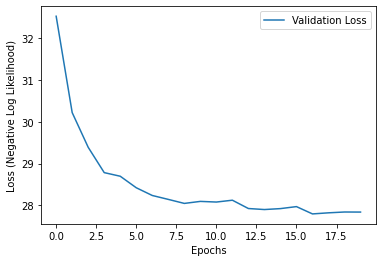

In [ ]:
plot_loss(new_dir + "/data/loss.txt",show=True,save=new_dir+"/figures/loss.png",validation_only=True)

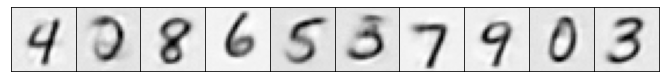

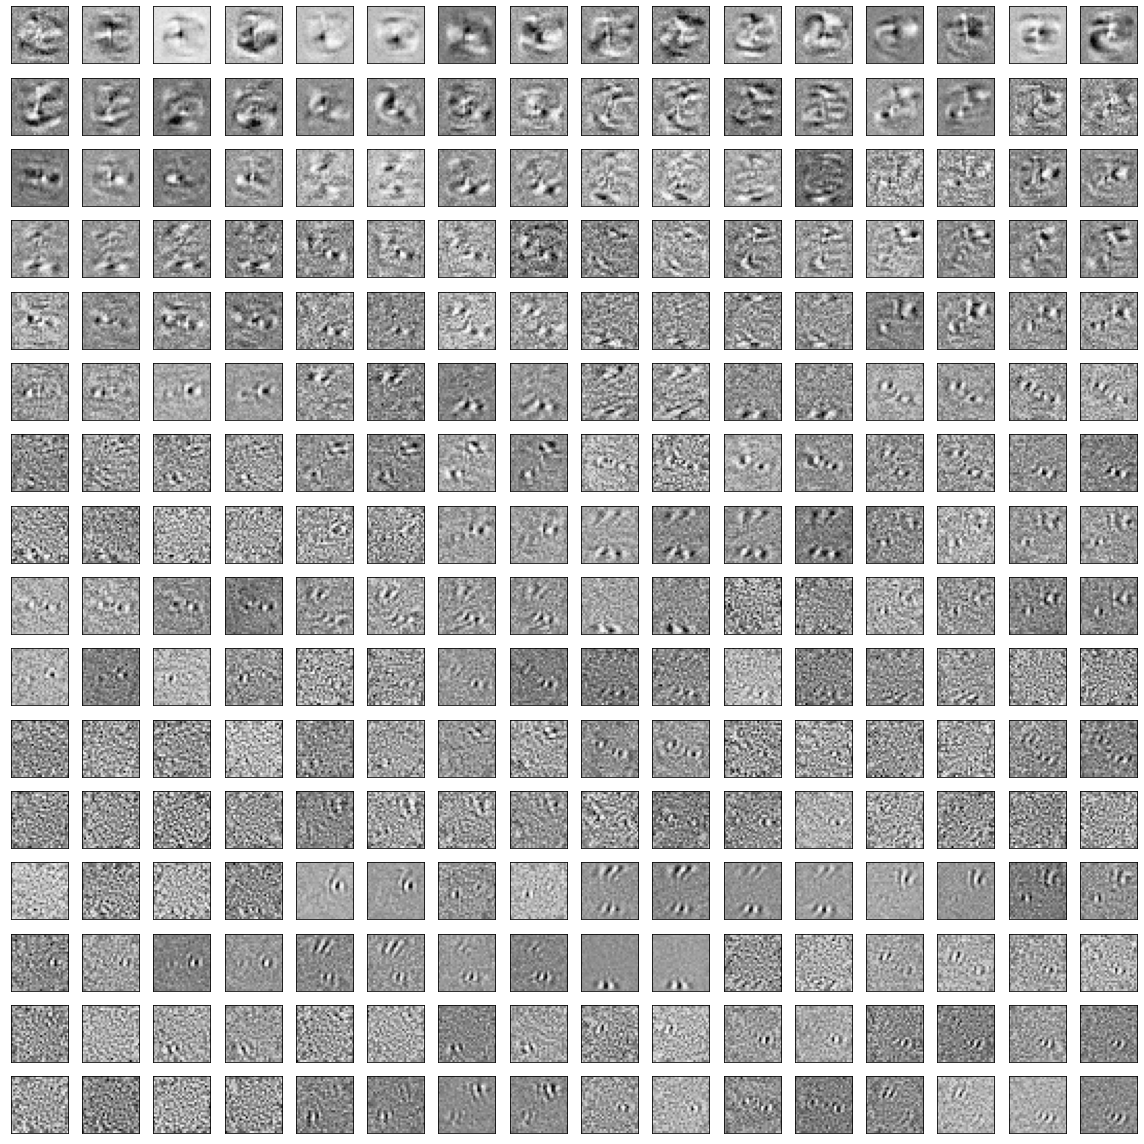

In [ ]:
plot_psi(psi, show=True, rgb=False)
plot_w(w, show=True, rgb=False)
# plot_w(w, show=True, rgb=False, cols=10)

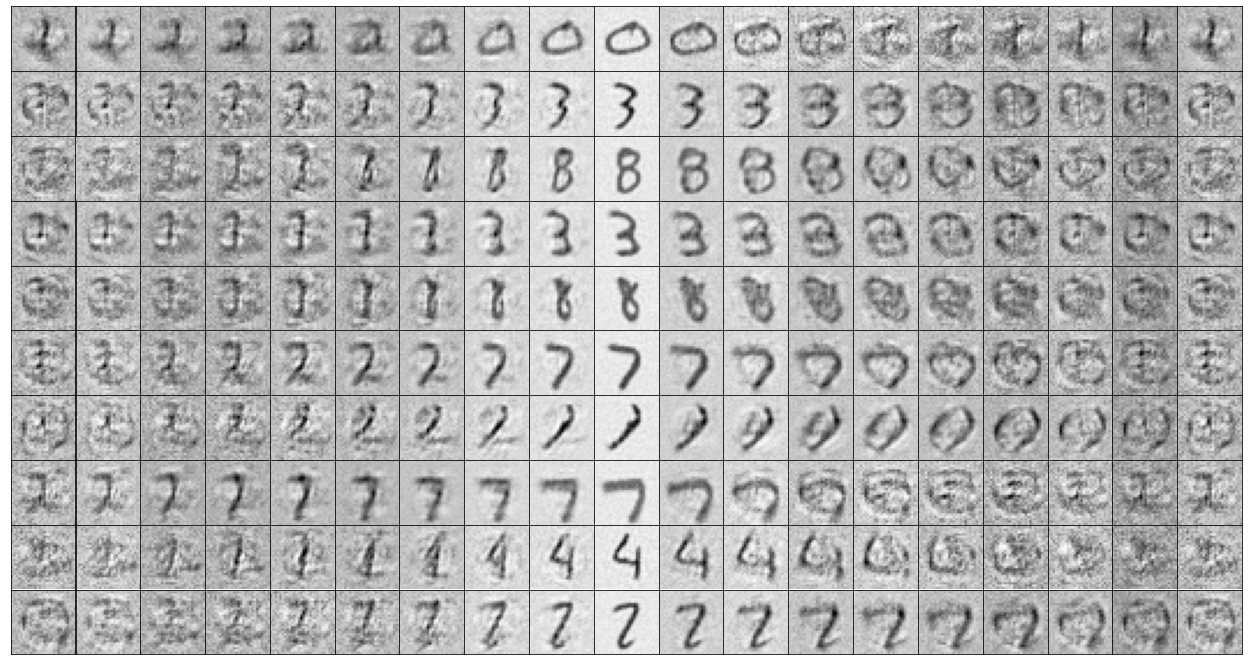

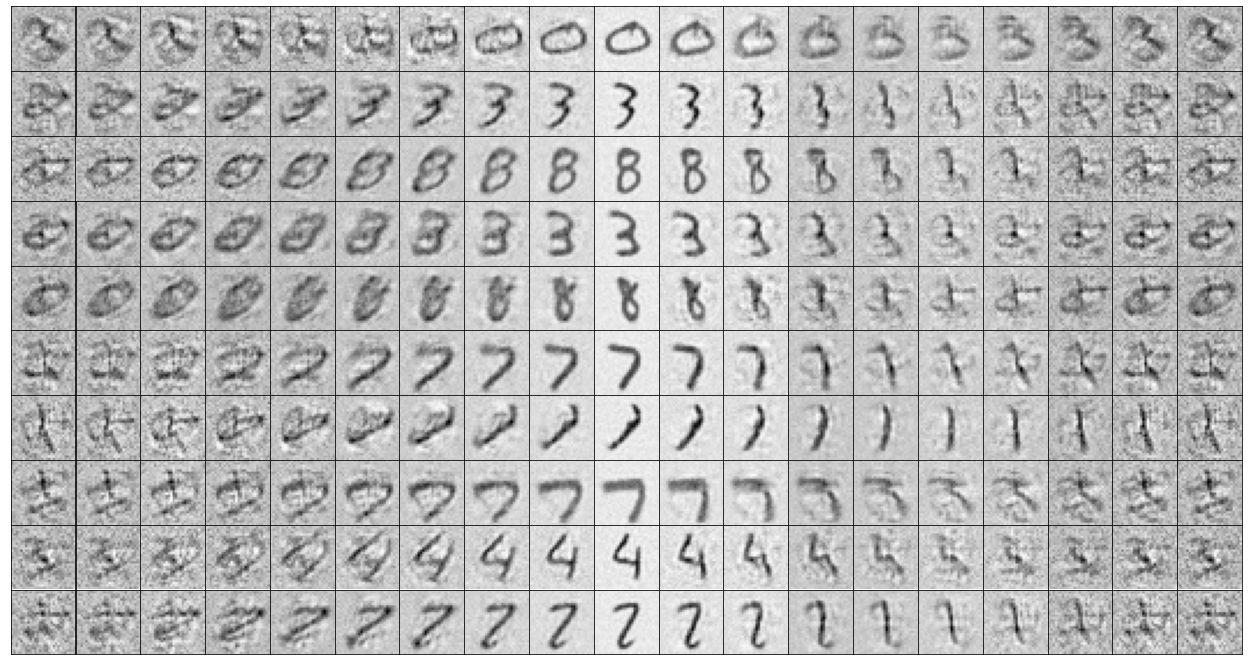

In [ ]:
theta1 = 0.0*np.pi/180
theta2 = theta1 + 90.0*np.pi/180
s1 = np.array([np.cos(theta1),np.sin(theta1)])
s2 = np.array([np.cos(theta2),np.sin(theta2)])
s1 = s1 / np.max(np.abs(s1))
s2 = s2 / np.max(np.abs(s2))

plot_operator(s1,show=True, rgb=False)
plot_operator(s2,show=True, rgb=False)

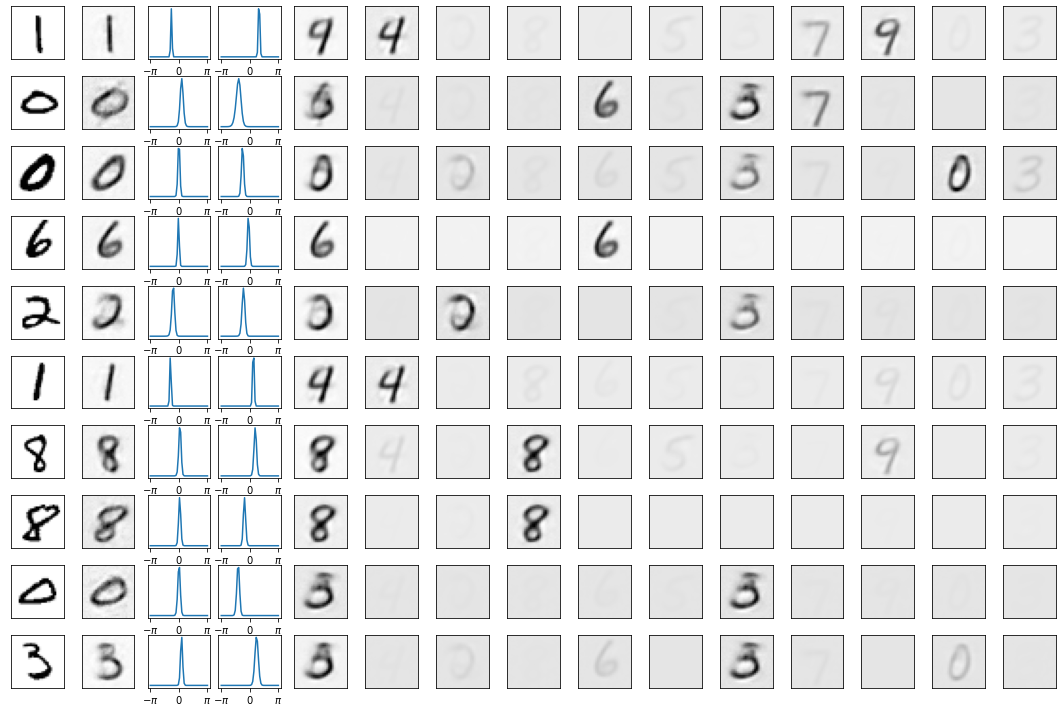

In [ ]:
plot_reconstruction(test_dl, alpha_0=alpha_0, show=True, three_d=False, rgb=False, plot_marginals=True, N=N_samples, expanded=True, M=10)

# Sparse Coding

In [ ]:
def plot_sc_reconstruction(dl, show=False, save=None, M=10, expanded=True, box_margins=[0.05,0.95,0.95,0.075], hspace=0.35):
    # Generate Data
    y = next(iter(dl))[:M]

    alpha, res = sc.FISTA(y.t(),psi,lamb,steps,s,useMAGMA=True) # (K,B), (D,B)
    alpha, res = alpha.t(), res.t() # (B,K), (B,D)
    
    recon = torch.einsum('dk,bk->bd',psi,alpha)
    
    cols = 2
    fig = plt.figure(figsize=(cols,1.5*M))
    for i in range(M):
        fig.add_subplot(M,cols,i*cols+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(y[i].cpu().reshape((dim,dim)),cmap="Greys")
        fig.add_subplot(M,cols,i*cols+1+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(recon[i].cpu().reshape((dim,dim)),cmap="Greys")
#     plt.tight_layout()
    plt.subplots_adjust(left=box_margins[0], right=box_margins[1], top=box_margins[2], bottom=box_margins[3], hspace=hspace, wspace=0.5)
    if save is not None:
        plt.savefig(save.format(1))
    if show:
        plt.show()
    plt.close(fig)
    
    fig = plt.figure(figsize=(4.5,1.5*M))
    
    for i in range(M):
        fig.add_subplot(M,1,i+1)
        plt.xticks([])
        plt.yticks(fontsize='x-large')
        plt.xlim(-0.5,9.5)
        plt.bar(np.arange(alpha.size()[1]), alpha[i].cpu())
#         ax = plt.gca()
#         ax.margins(x=0.0)
#         ax.use_sticky_edges = False
#         ax.autoscale_view(scaley=True)
    plt.subplots_adjust(left=0.125, right=box_margins[1], top=box_margins[2], bottom=box_margins[3], hspace=hspace)
    if save is not None:
        plt.savefig(save.format(2))
    if show:
        plt.show()
    plt.close(fig)

In [ ]:
B = 100

# Initialize dataloader
dl, test_dl, dim, D, num_train_batches, num_test_batches = get_MNIST_dataloader(B,cuda=True)
# dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dr=[-75.0,75.0],ds=[0.5,1.0],cuda=True) # Rotation and Scaling
# dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dx=[-0.25,0.25],dy=[-0.25,0.25],cuda=True) # Horizontal and Vertical Translation

# Initialize sparse coding dictionary
K = 100
psi = torch.rand(D,K).cuda() # (D,K)
psi = f.normalize(psi, dim=0)

epoch, T = 0, 0

In [ ]:
eta_psi = 0.05

s = 0.1
lamb = 1.0 # sparsity cost
epochs = 20 # 20000
save_skip = 100
steps = 20
hess = torch.zeros(K).cuda()
minact = 0.001
hist_len = 300.0
use_hess = False
shuffle = True
save = True
test = True
plot = False

In [ ]:
# dataset_type = "sc_rot_75_scale_0.5-1.0_"
# dataset_type = "sc_ver_hor_"
dataset_type = "sc_"
new_dir = "data/{}MNIST{}x{}/s{}_B{}_K{}_lamb{}_epsi{}_steps{}".format(dataset_type,dim,dim,s,B,K,lamb,eta_psi,steps)
if use_hess:
    new_dir = new_dir + "_hess_minact{}_hist{}".format(minact,hist_len)
if shuffle:
    new_dir = new_dir + "_shuffle"
new_dir = new_dir + "_5"
if save:
    if not os.path.isdir("data/{}MNIST{}x{}".format(dataset_type,dim,dim)):
        os.mkdir("data/{}MNIST{}x{}".format(dataset_type,dim,dim))
    os.mkdir(new_dir)
    os.mkdir(new_dir + "/data")
    os.mkdir(new_dir + "/figures")
    os.mkdir(new_dir + "/videos")
data_path = new_dir + "/data/{}_epoch_{}.txt"
fig_path = new_dir + "/figures/{}_epoch_{}.png"
video_path = new_dir + "/videos/{}_epoch_{}_batch_{}.mp4"

In [ ]:
while epoch < epochs:
    if shuffle:
        dl = dl.view(-1,dl.size()[-1])[torch.randperm(dl.size()[0]*dl.size()[1])].view(dl.size()) # shuffle
    # Reload dataloader
    it = iter(dl)
    test_it = iter(test_dl)
    
    # Training
    train_snr = 0.0
    while T < num_train_batches:
        t = int(epoch*num_train_batches+T+1)
        
        # Get data
        y = next(it) # (B,D)

        # Optimize alpha
        alpha, res = sc.FISTA(y.t(),psi,lamb,steps,s,useMAGMA=True,plot=plot) # (K,B), (D,B)
        alpha, res = alpha.t(), res.t() # (B,K), (B,D)
#         print(torch.isnan(alpha).any())

        # Calculate error
        snr = ((y**2).sum(dim=1)/(res**2).sum(dim=1)).mean()
        train_snr += snr
        
        hess = hess.mul((hist_len-1.0)/hist_len) + (alpha**2).mean(dim=0)/hist_len
        
        # Update psi
        if use_hess:
            old_psi = psi.clone()
            psi = sc.quadraticBasisUpdate(psi, res.t(), alpha.t(), minact, hess, eta_psi, s)
            if torch.isnan(psi).any():
                print("HI")
                psi = old_psi.clone()
            dpsi_length = torch.mean(torch.norm(psi - old_psi, dim=0))
        else:
            dpsi = eta_psi/s**2*(torch.einsum('bd,bk->dk',res,alpha)/B)
            new_psi = f.normalize(psi + dpsi, dim=0)
            dpsi_length = torch.mean(torch.norm(new_psi - psi, dim=0))
            psi = new_psi.clone()

        # Print error
        if T % save_skip == 0:
            print("Epoch {}, Batch {}: SNR1 - {:.3f}; Psi - {:.3f}".format(epoch, T, snr, dpsi_length))
        
        T += 1
    
    train_snr /= num_train_batches
    T = 0
    
    # Validation
    if test:
        test_snr = 0.0
        normed_psi = f.normalize(psi,dim=0)
        while T < num_test_batches:
            # Generate data
            y = next(test_it) # (B,D)

            # Optimize alpha
            alpha, res = sc.FISTA(y.t(),psi,lamb,steps,s,useMAGMA=True) # (K,B), (D,B)
            alpha, res = alpha.t(), res.t() # (B,K), (B,D)

            # Calculate error
            snr = ((y**2).sum(dim=1)/(res**2).sum(dim=1)).mean()
            test_snr += snr
            
            T += 1
            
        test_snr /= num_test_batches
        T = 0
        print("Epoch {}: Test SNR - {:.3f}".format(epoch, test_snr))
    
    epoch += 1
#     if epoch % 20 == 0:
#         eta_psi /= 2.0
    
    if save and test:
        # Save data
        np.savetxt(data_path.format("psi",epoch), psi.cpu().numpy())
        save_loss(train_snr, test_snr, new_dir + "/data/snr.txt")
        save_loss(alpha.norm(dim=1).mean().cpu().numpy(),0.0, new_dir + "/data/l1_norm.txt")

        # Plot figures
        plot_psi(psi,save=fig_path.format("psi",epoch))
#         plot_sc_reconstruction(dl, save=fig_path.format("recon",epoch))
        plot_sc_reconstruction(dl, save=fig_path.format("recon",epoch), expanded=False)

Epoch 0, Batch 0: SNR1 - 1.217; Psi - 0.012
Epoch 0, Batch 100: SNR1 - 4.287; Psi - 0.010
Epoch 0, Batch 200: SNR1 - 6.380; Psi - 0.011
Epoch 0, Batch 300: SNR1 - 6.925; Psi - 0.012
Epoch 0, Batch 400: SNR1 - 8.949; Psi - 0.013
Epoch 0, Batch 500: SNR1 - 9.743; Psi - 0.013
Epoch 0: Test SNR - 10.680
Epoch 1, Batch 0: SNR1 - 10.361; Psi - 0.015
Epoch 1, Batch 100: SNR1 - 10.651; Psi - 0.016
Epoch 1, Batch 200: SNR1 - 10.308; Psi - 0.017
Epoch 1, Batch 300: SNR1 - 11.552; Psi - 0.017
Epoch 1, Batch 400: SNR1 - 11.135; Psi - 0.017
Epoch 1, Batch 500: SNR1 - 13.248; Psi - 0.014
Epoch 1: Test SNR - 12.562
Epoch 2, Batch 0: SNR1 - 11.676; Psi - 0.012
Epoch 2, Batch 100: SNR1 - 12.535; Psi - 0.012
Epoch 2, Batch 200: SNR1 - 13.292; Psi - 0.010
Epoch 2, Batch 300: SNR1 - 12.170; Psi - 0.011
Epoch 2, Batch 400: SNR1 - 13.009; Psi - 0.011
Epoch 2, Batch 500: SNR1 - 12.539; Psi - 0.011
Epoch 2: Test SNR - 13.765
Epoch 3, Batch 0: SNR1 - 13.330; Psi - 0.011
Epoch 3, Batch 100: SNR1 - 13.641; Psi -